# Regression Discontinuity Design

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "regression_discontinuity_glm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Data Generation

In [3]:
n = 80
c = 40
delta = 40

x = rng.uniform(low=-20, high=80, size=n)

d = (x > c).astype(float)

intercept = 25
slope = 2
quadratic = - 4e-3
cubic = 3e-4

y0 = (
    intercept
    + slope * x
    + quadratic * x**2
    + cubic * x**3
    + 0 * d
    + rng.normal(loc=0, scale=30, size=n)
)
y = y0 + delta * d

data = pd.DataFrame(data={"x": x, "d": d, "y0": y0, "y": y})
mask = "0 < y0 and 0 < y"
data = data.query(expr=mask).sort_values(by="x").reset_index(drop=True)

y_minus = intercept + slope * c + quadratic * c**2
y_plus = y_minus + delta

[Text(0.5, 1.0, 'Treatment Effect'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

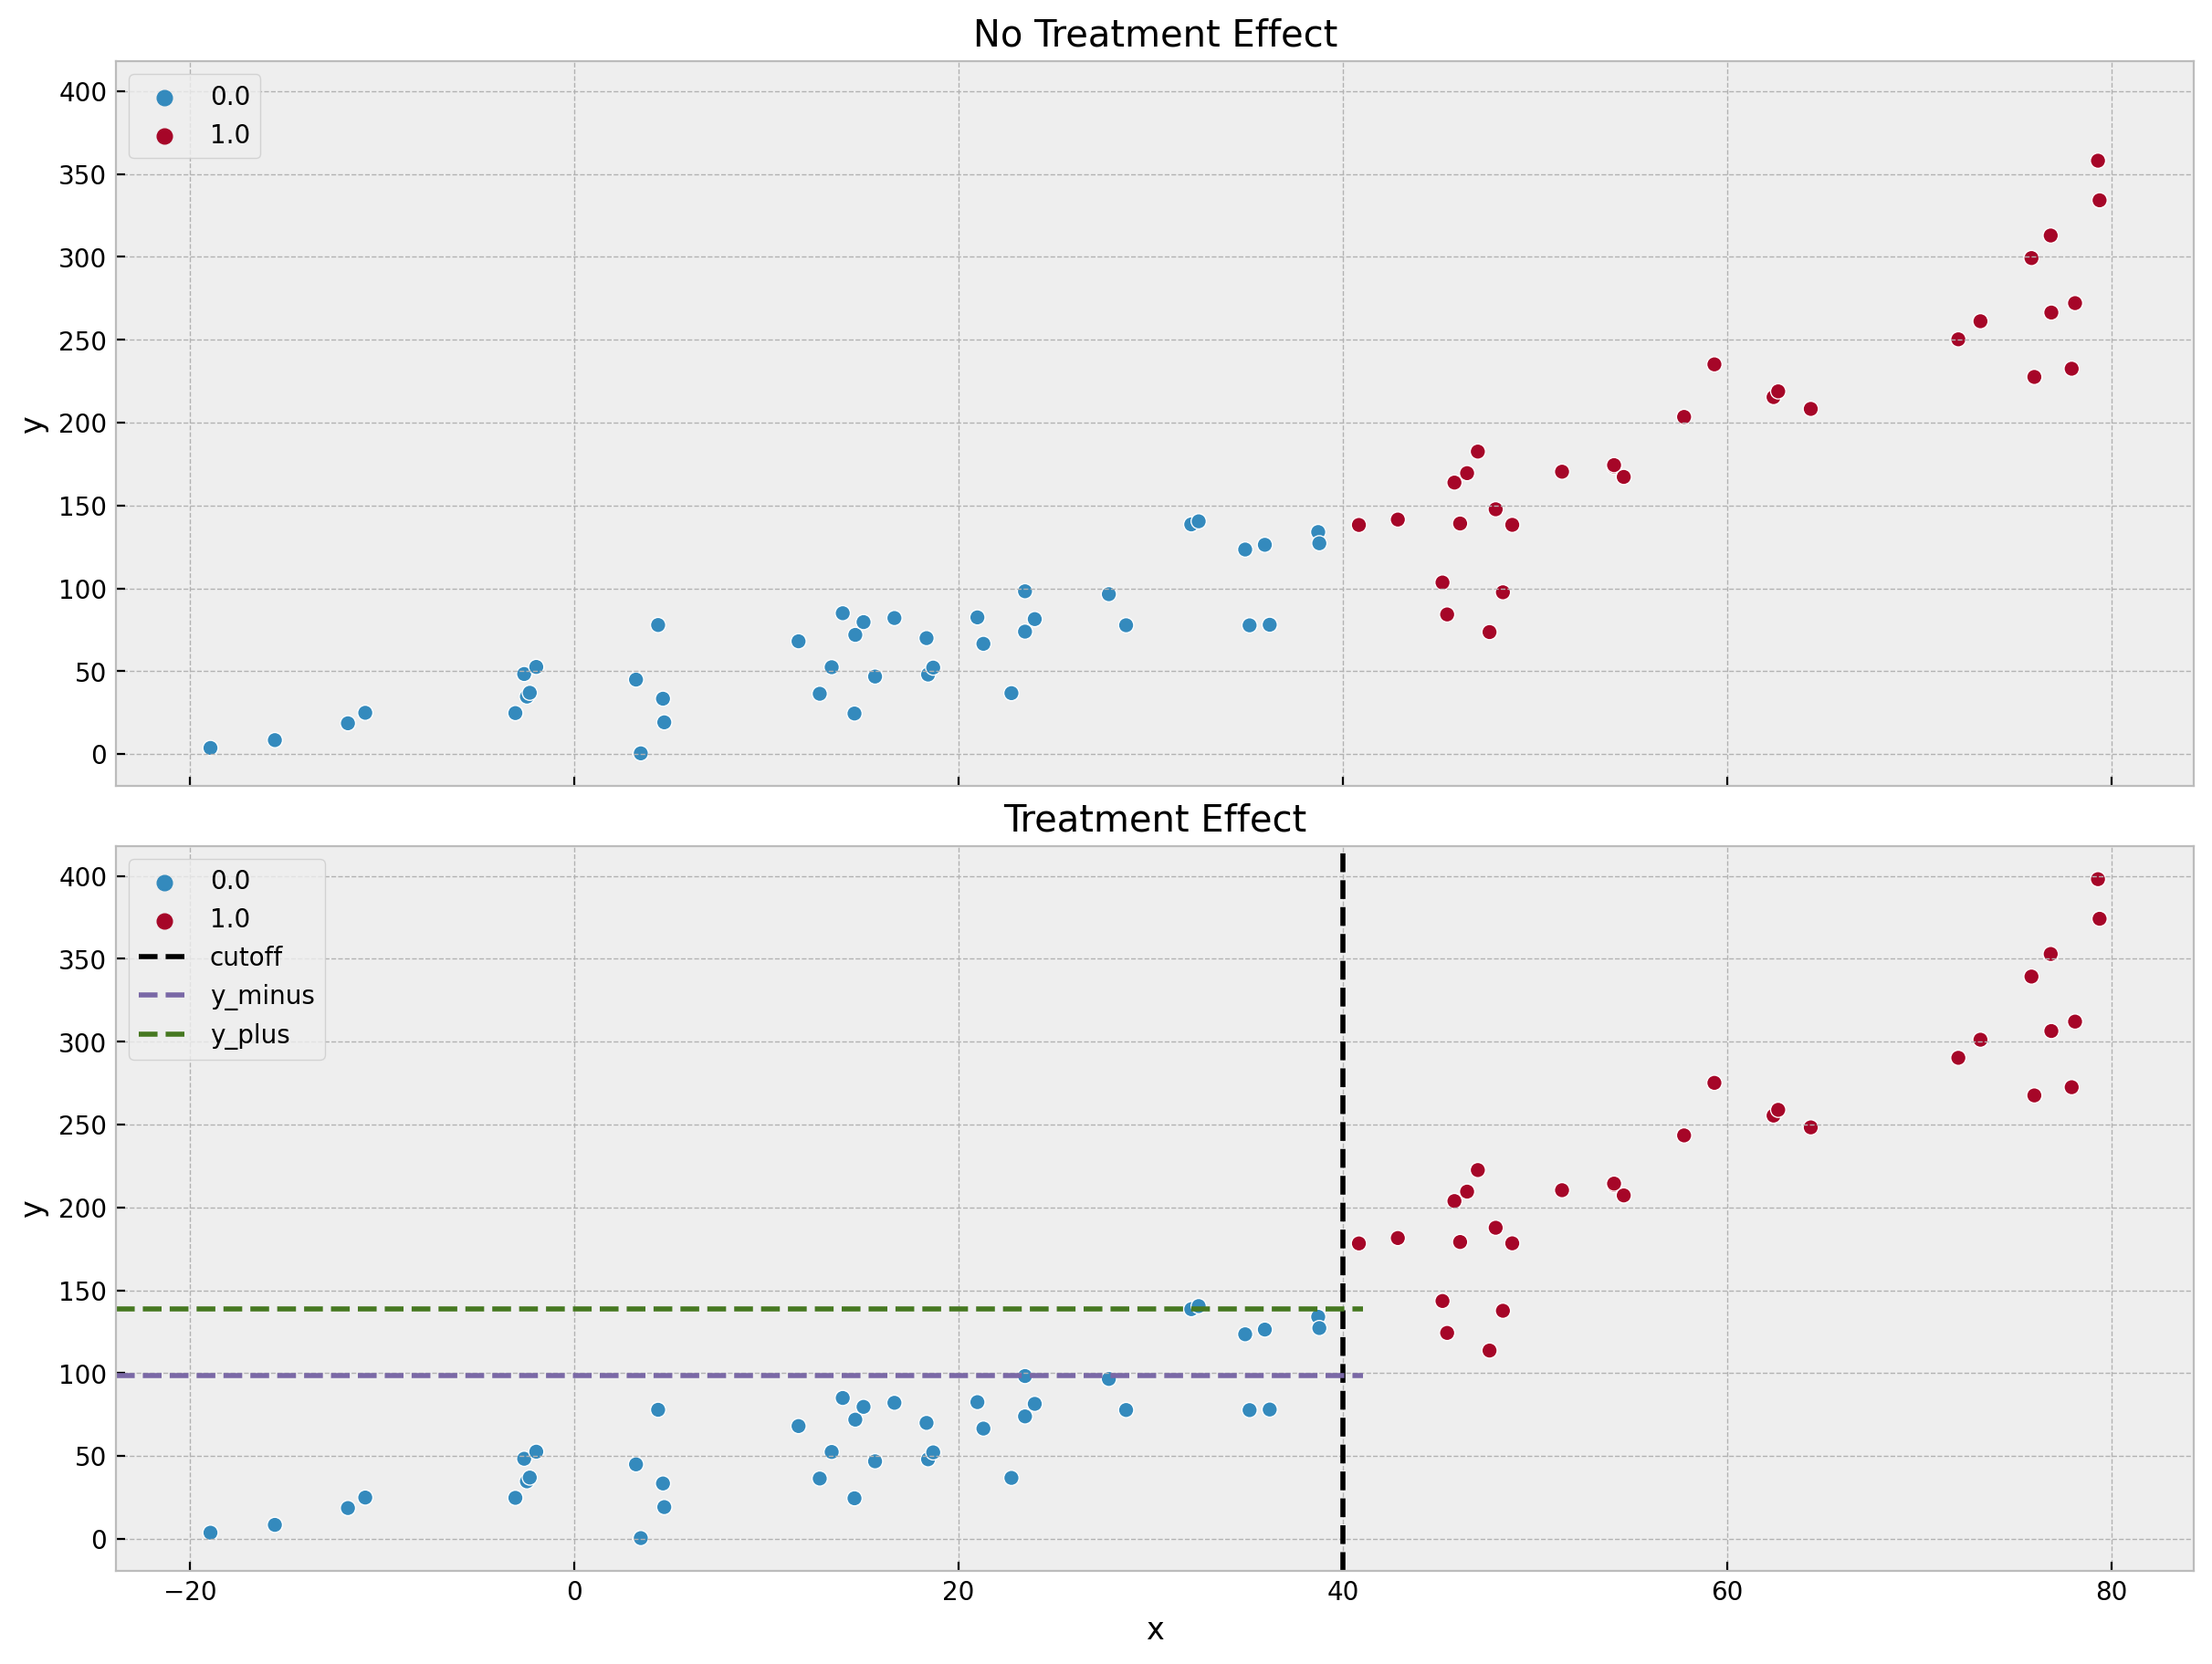

In [4]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(data=data, x="x", y="y0", hue="d", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(title="No Treatment Effect", xlabel="x", ylabel="y")
sns.scatterplot(data=data, x="x", y="y", hue="d", ax=ax[1])
ax[1].axvline(x=c, color="black", linestyle="--", label="cutoff")
ax[1].axhline(
    y=y_minus,
    xmax=0.6,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax[1].axhline(
    y=y_plus,
    xmax=0.6,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax[1].legend(loc="upper left")
ax[1].set(title="Treatment Effect", xlabel="x", ylabel="y")


In [5]:
delta_true = y_plus - y_minus
delta_true


40.0

In [6]:
data["x_c"] = data["x"] - c

[Text(0.5, 1.0, 'Centered Synthetic Data'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y')]

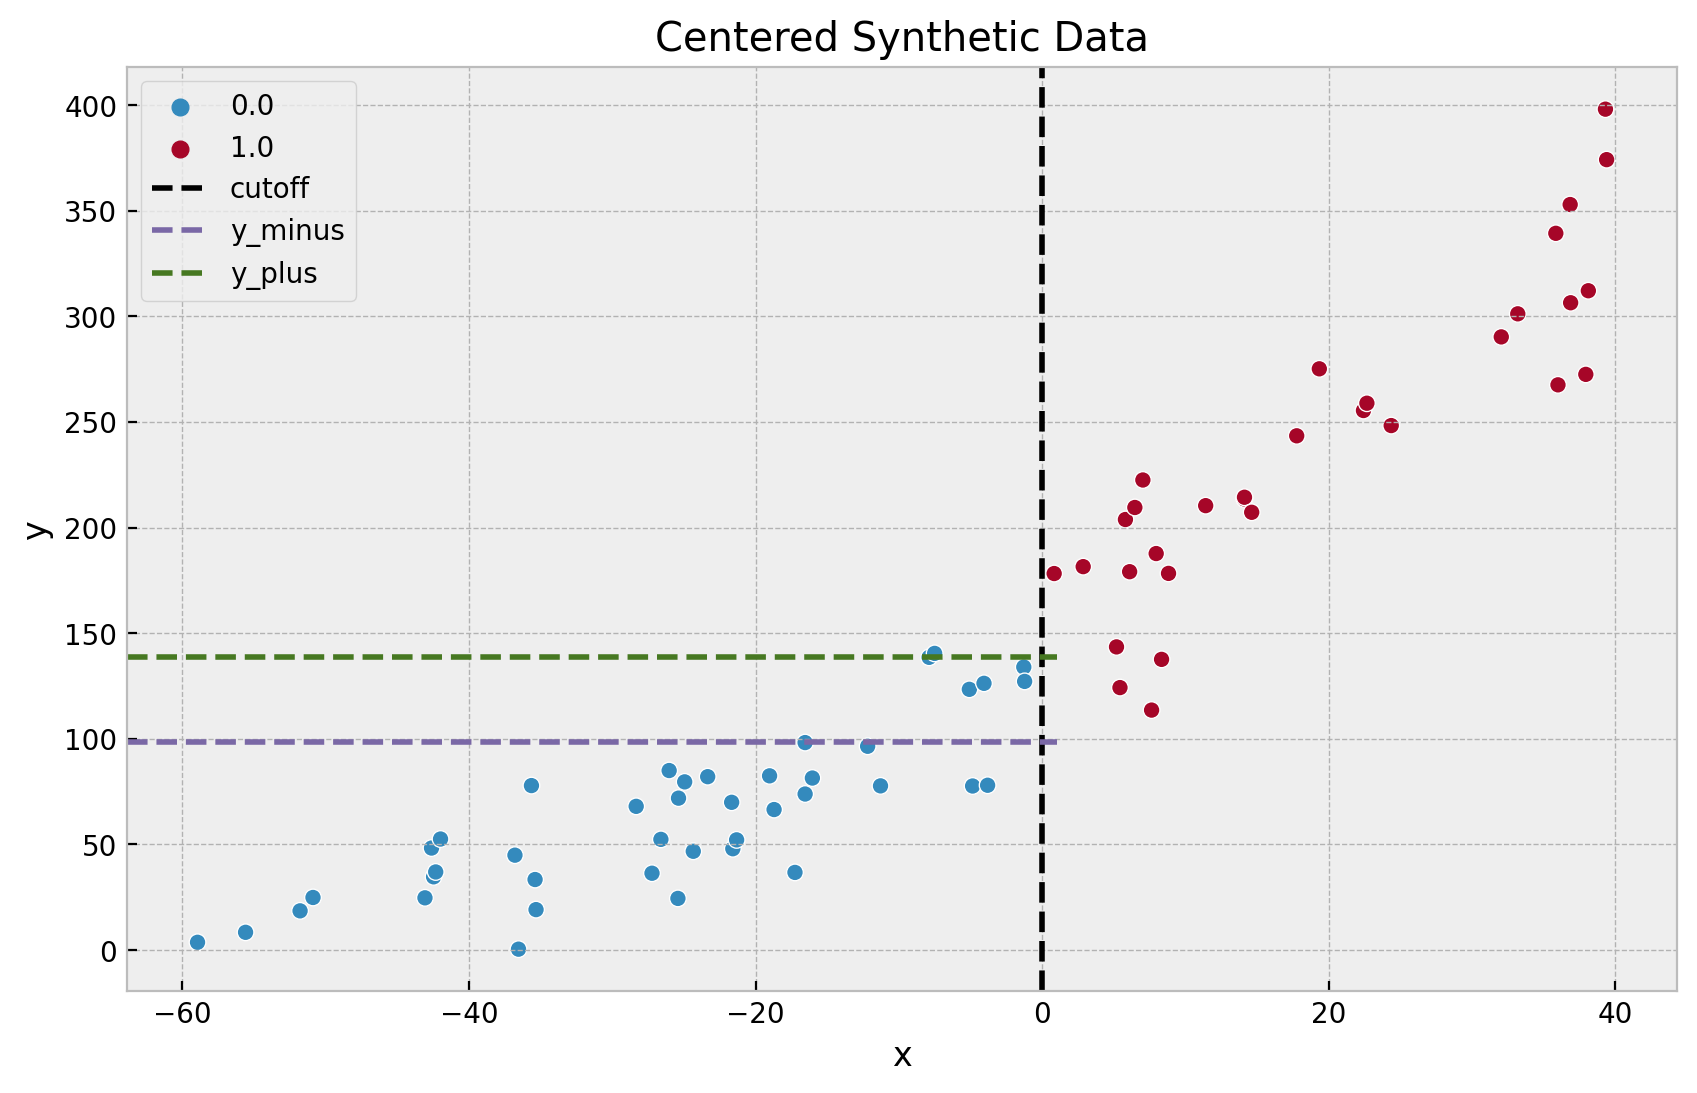

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", hue="d", ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
ax.axhline(
    y=y_minus,
    xmax=0.6,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax.axhline(
    y=y_plus,
    xmax=0.6,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax.legend(loc="upper left")
ax.set(title="Centered Synthetic Data", xlabel="x", ylabel="y")

In [8]:
data["x_c"] = data["x"] - c

obs_idx = data.index.to_numpy()
x_c = data["x_c"].to_numpy()
d = data["d"].to_numpy()
y = data["y"].to_numpy()


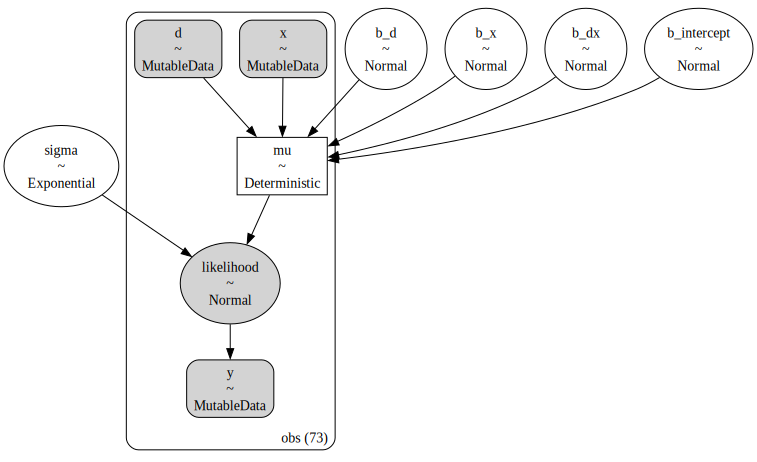

In [9]:
with pm.Model(coords={"obs": obs_idx}) as gaussian_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=150, sigma=100)
    b_x = pm.Normal(name="b_x", mu=0, sigma=6)
    b_d = pm.Normal(name="b_d", mu=0, sigma=50)
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=6)
    sigma = pm.Exponential(name="sigma", lam=1 / 50)
    # --- Deterministic Variables ---
    mu = pm.Deterministic(
        name="mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gaussian_model)


In [10]:
with gaussian_model:
    gaussian_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Linear Regression Model - Prior Predictive Distribution')]

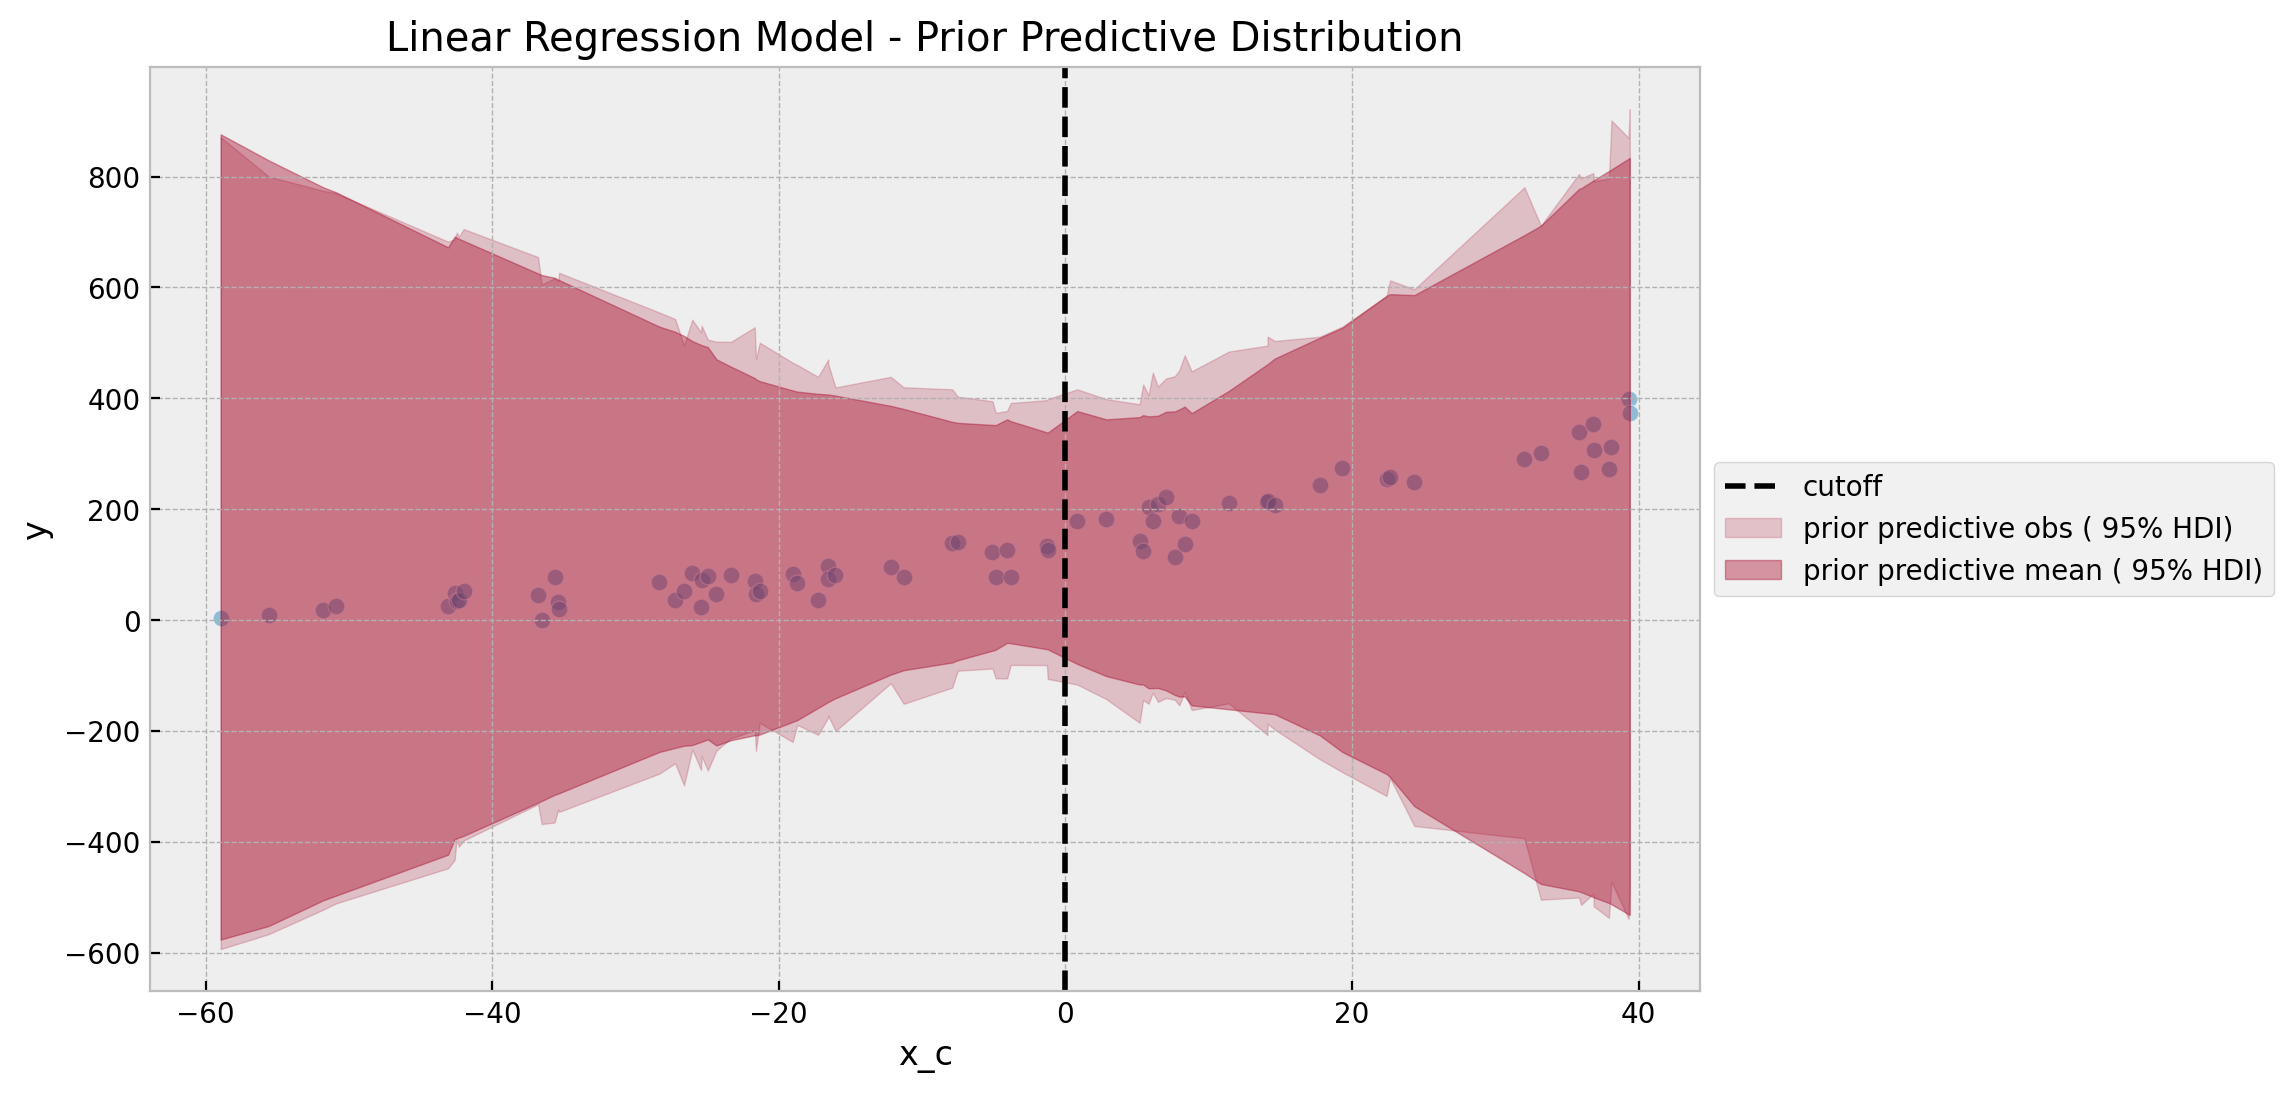

In [11]:
alpha = 0.05

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model - Prior Predictive Distribution")

In [12]:
with gaussian_model:
    gaussian_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    gaussian_posterior_predictive = pm.sample_posterior_predictive(
        trace=gaussian_idata, random_seed=rng
    )

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.049292
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:04.927156
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:00.292073


In [13]:
gaussian_idata["sample_stats"]["diverging"].sum().item()


0

In [14]:
az.summary(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept  116.466   7.959  101.863  131.785      0.075    0.053   11363.0   
b_x            2.036   0.269    1.523    2.530      0.002    0.002   11616.0   
b_d           27.889  11.404    6.023   48.625      0.096    0.068   14251.0   
b_dx           2.840   0.458    1.990    3.713      0.004    0.003   15219.0   
sigma         26.951   2.339   22.746   31.377      0.017    0.012   20354.0   

             ess_tail  r_hat  
b_intercept   14345.0    1.0  
b_x           14109.0    1.0  
b_d           16095.0    1.0  
b_dx          16009.0    1.0  
sigma         18209.0    1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Linear Regression Model - Trace')

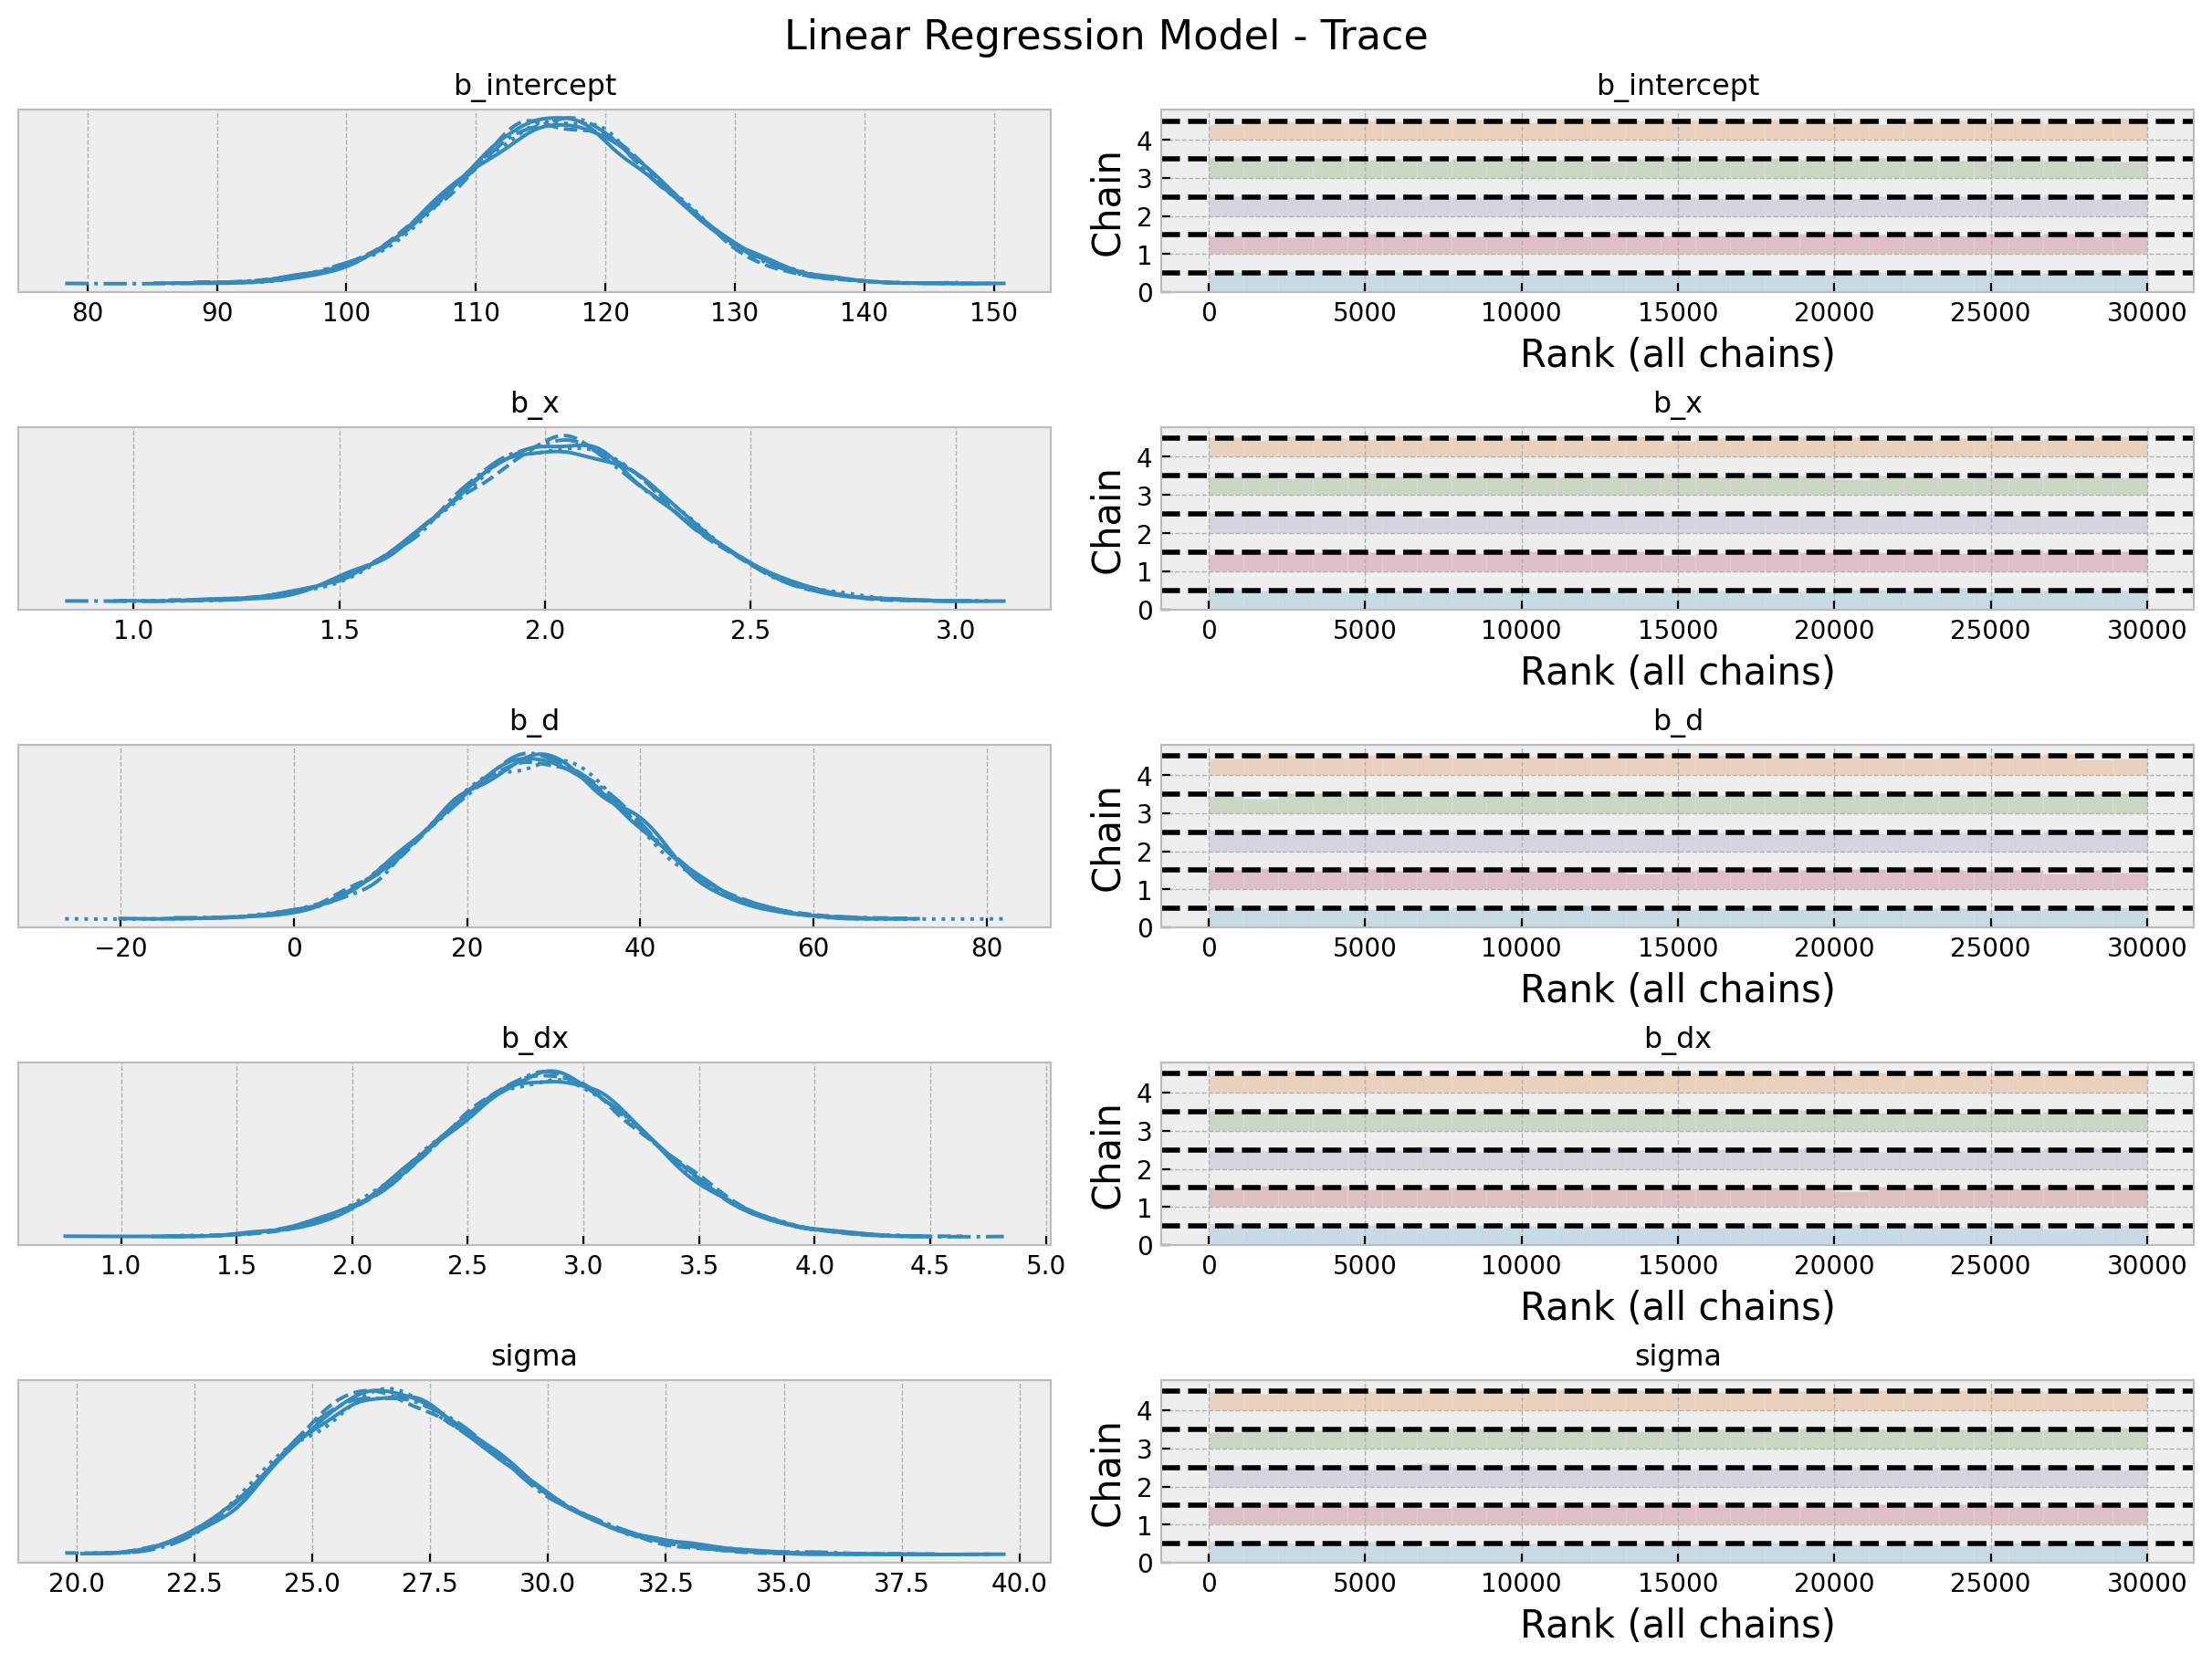

In [15]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)


[Text(0.5, 1.0, 'Linear Regression Model')]

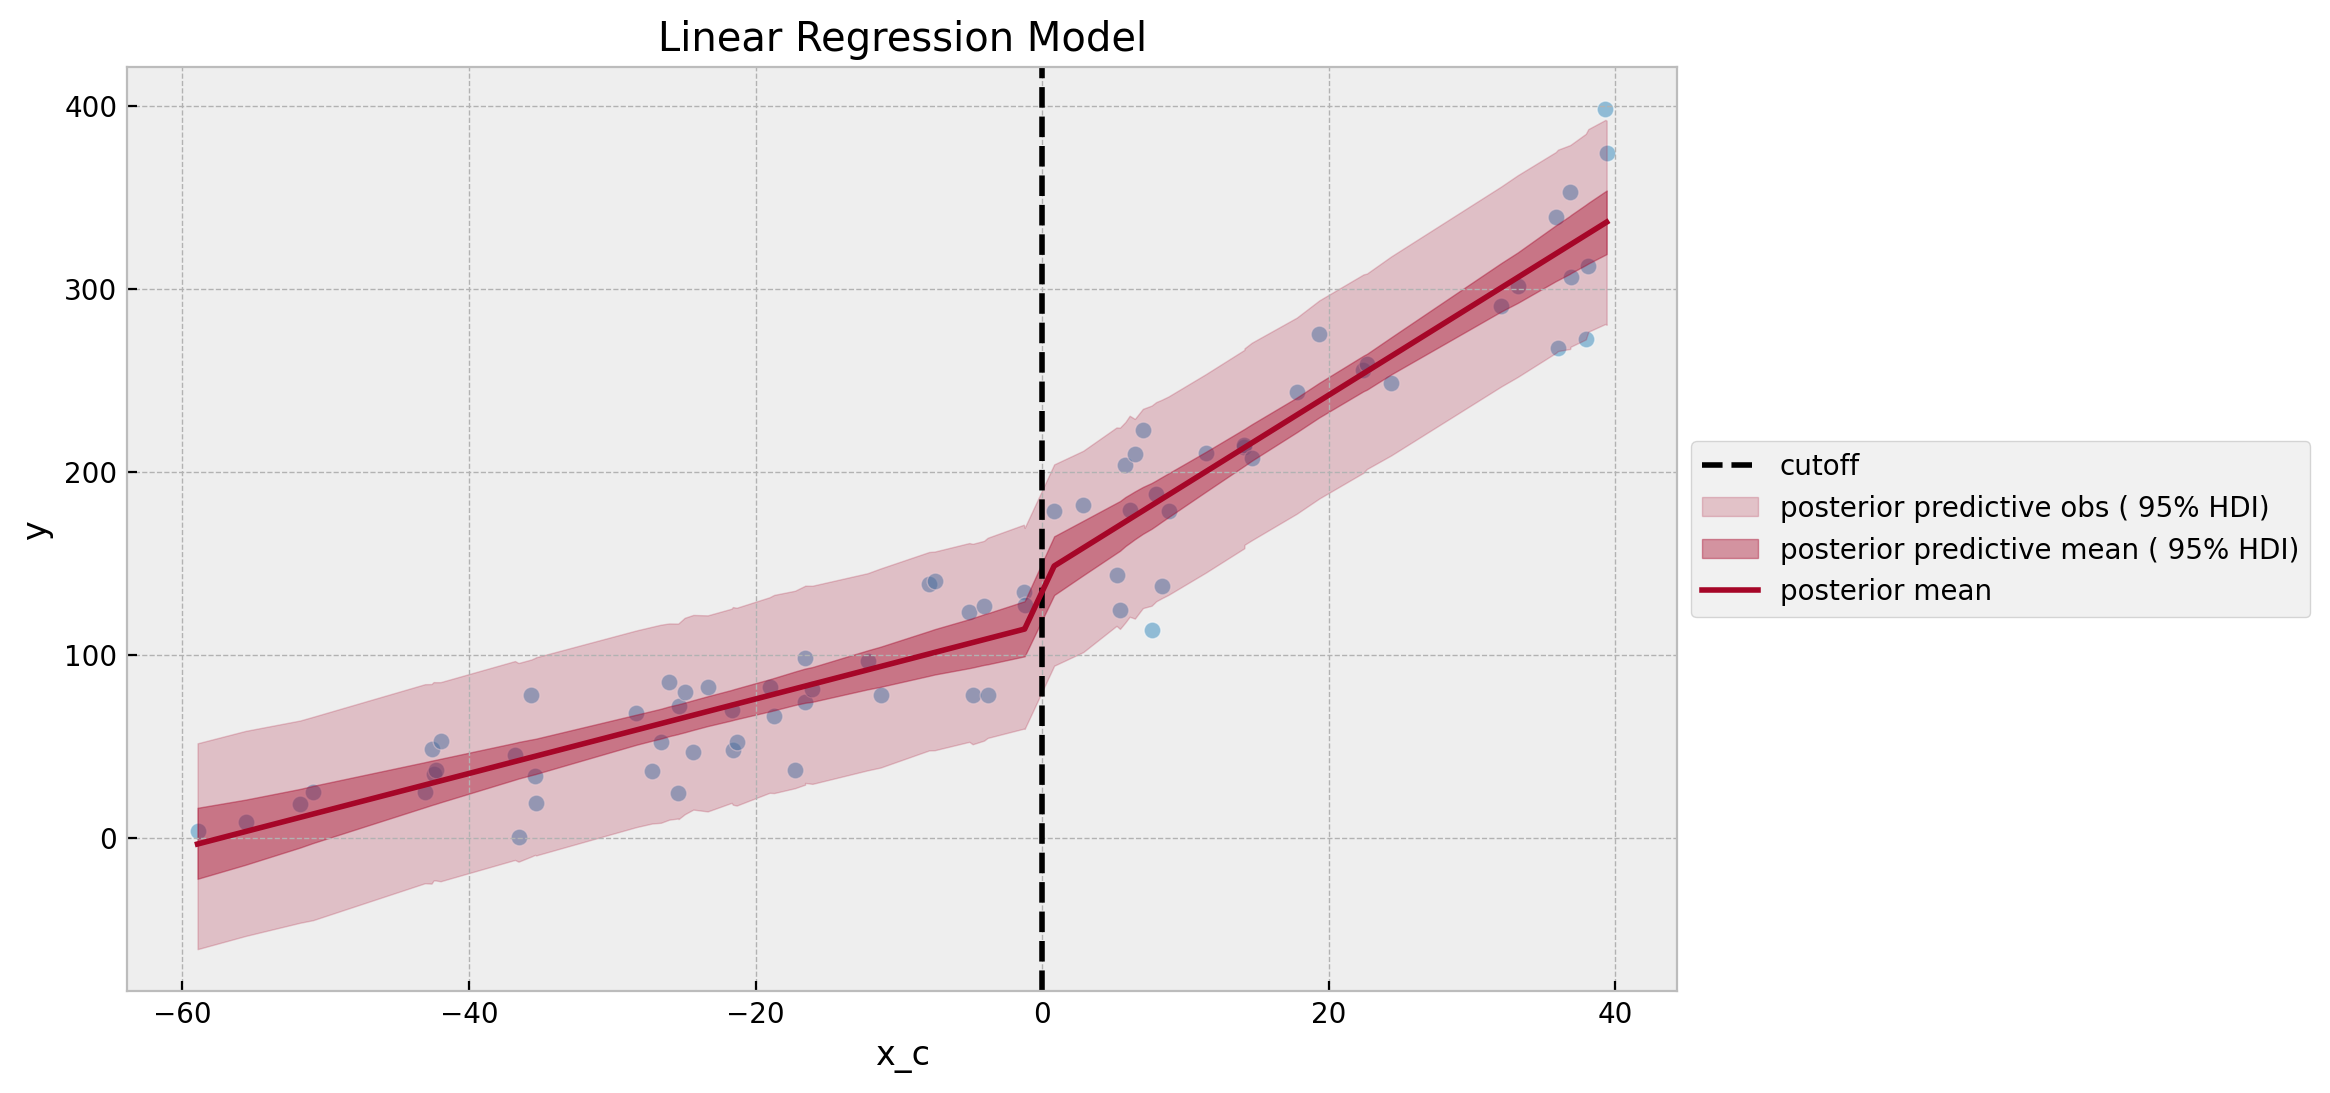

In [16]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gaussian_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model")

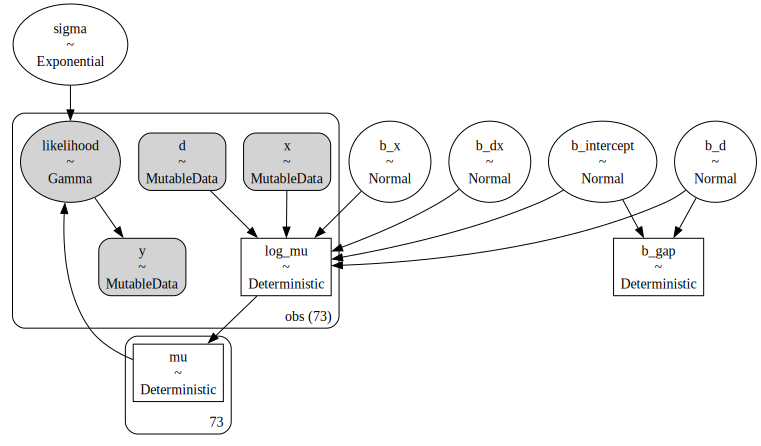

In [17]:
with pm.Model(coords={"obs": obs_idx}) as gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(100), sigma=np.log(3.3))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.01))
    b_d = pm.Normal(name="b_d", mu=0, sigma=np.log(1.5))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gamma_model)


In [18]:
with gamma_model:
    gamma_prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Gamma Regression Model - Prior Predictive Distribution')]

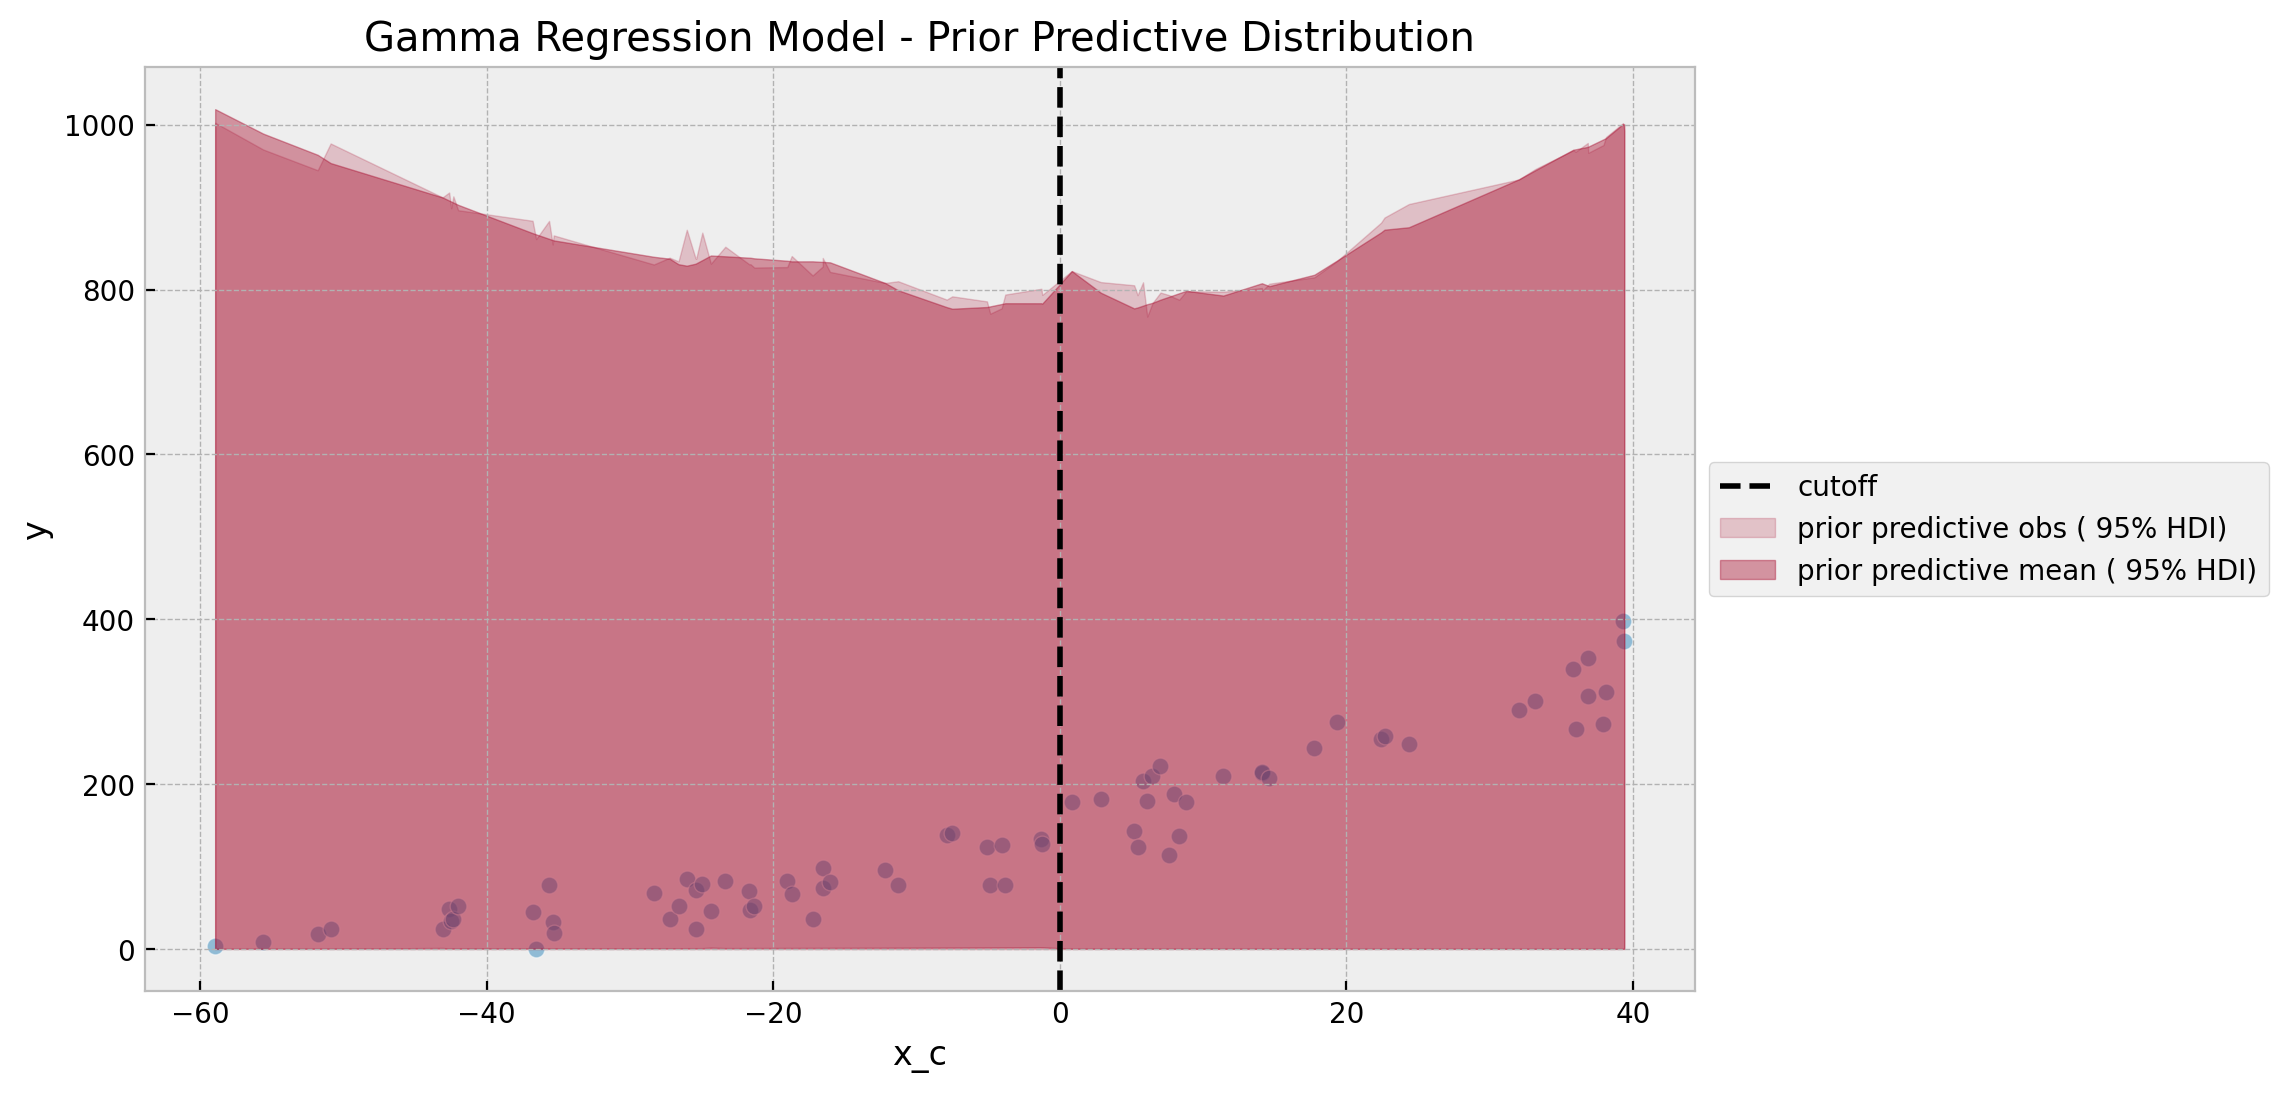

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model - Prior Predictive Distribution")

[Text(0.5, 1.0, 'Gamma Regression Model - Discontinuity Prior Predictive Distribution'),
 (-200.0, 200.0)]

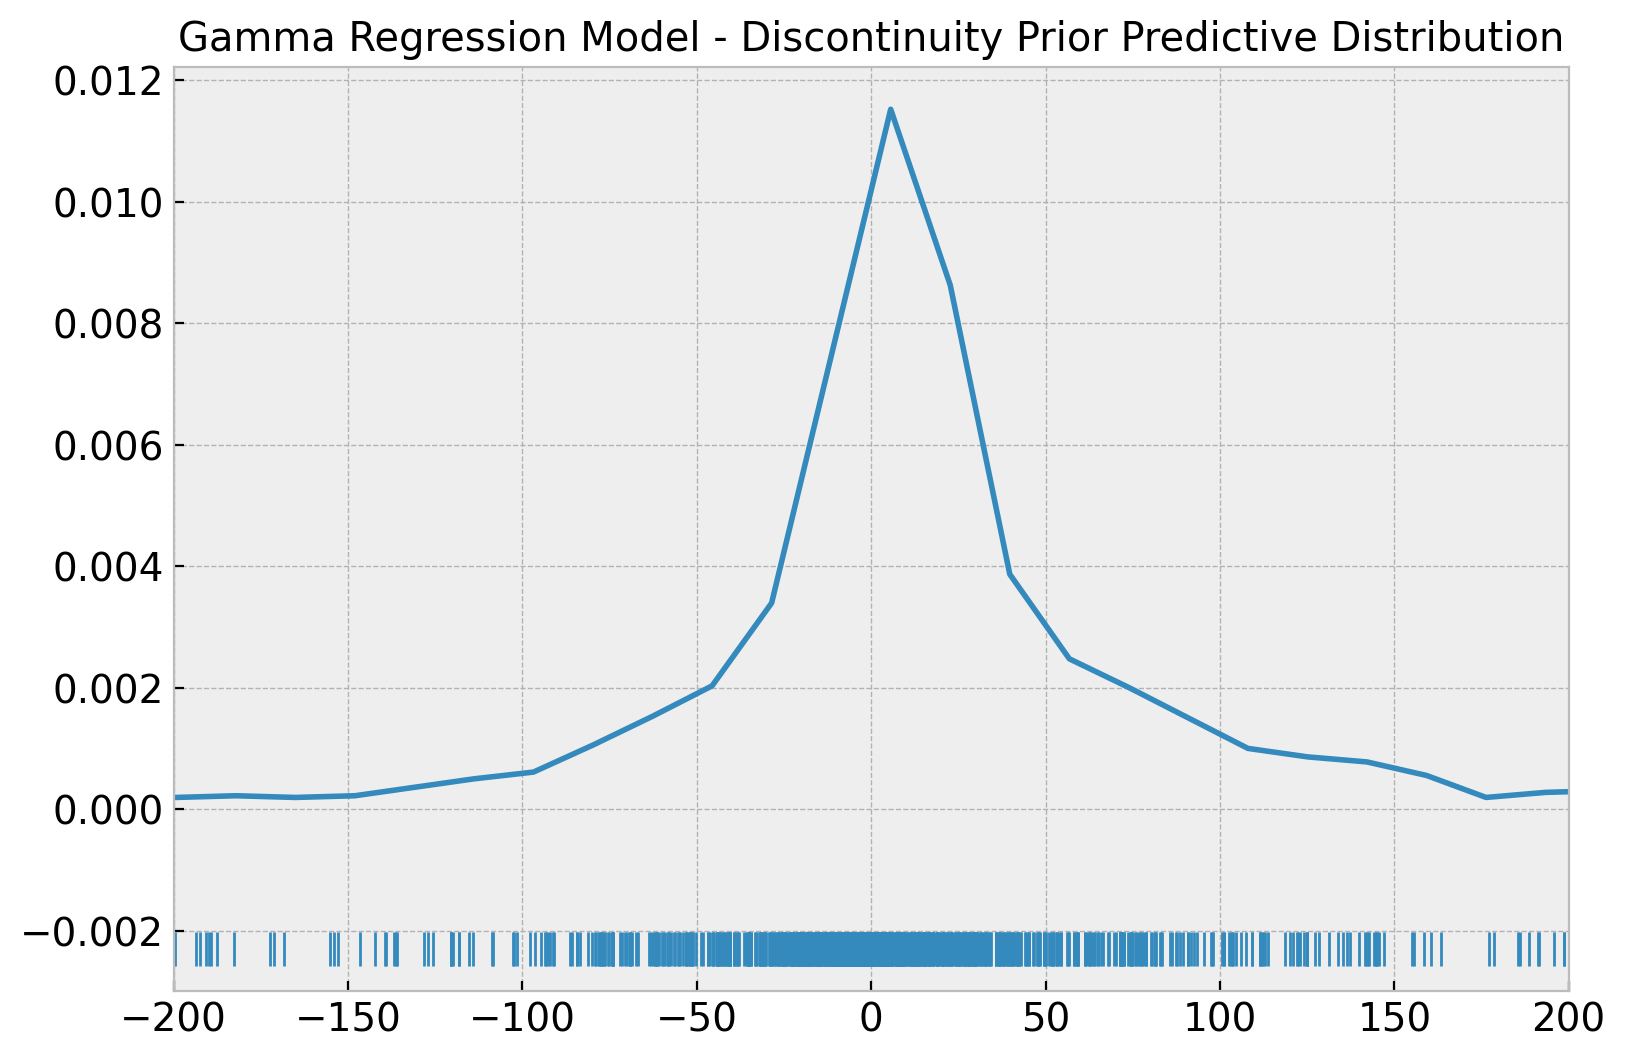

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))
az.plot_dist(
    values=az.extract(data=gamma_prior_predictive, group="prior", var_names=["b_gap"]),
    rug=True,
    ax=ax,
)
ax.set(
    title="Gamma Regression Model - Discontinuity Prior Predictive Distribution",
    xlim=(-2e2, 2e2),
)

In [21]:
with gamma_model:
    gamma_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=gamma_idata, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.755983
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:08.380404
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:00.279680


In [22]:
gamma_idata["sample_stats"]["diverging"].sum().item()


0

In [23]:
az.summary(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.811   0.090   4.637    4.974      0.001    0.001    7782.0   
b_x           0.026   0.004   0.020    0.033      0.000    0.000    7852.0   
b_d           0.235   0.103   0.043    0.432      0.001    0.001    8452.0   
b_dx         -0.006   0.004  -0.014    0.001      0.000    0.000    8954.0   
sigma        31.398   3.053  25.880   37.133      0.028    0.020   12086.0   
b_gap        32.272  13.539   6.848   57.998      0.142    0.103    9119.0   

             ess_tail  r_hat  
b_intercept    9042.0    1.0  
b_x            9236.0    1.0  
b_d            9633.0    1.0  
b_dx          11056.0    1.0  
sigma         13991.0    1.0  
b_gap         11324.0    1.0

Text(0.5, 0.98, 'Gamma Regression Model - Trace')

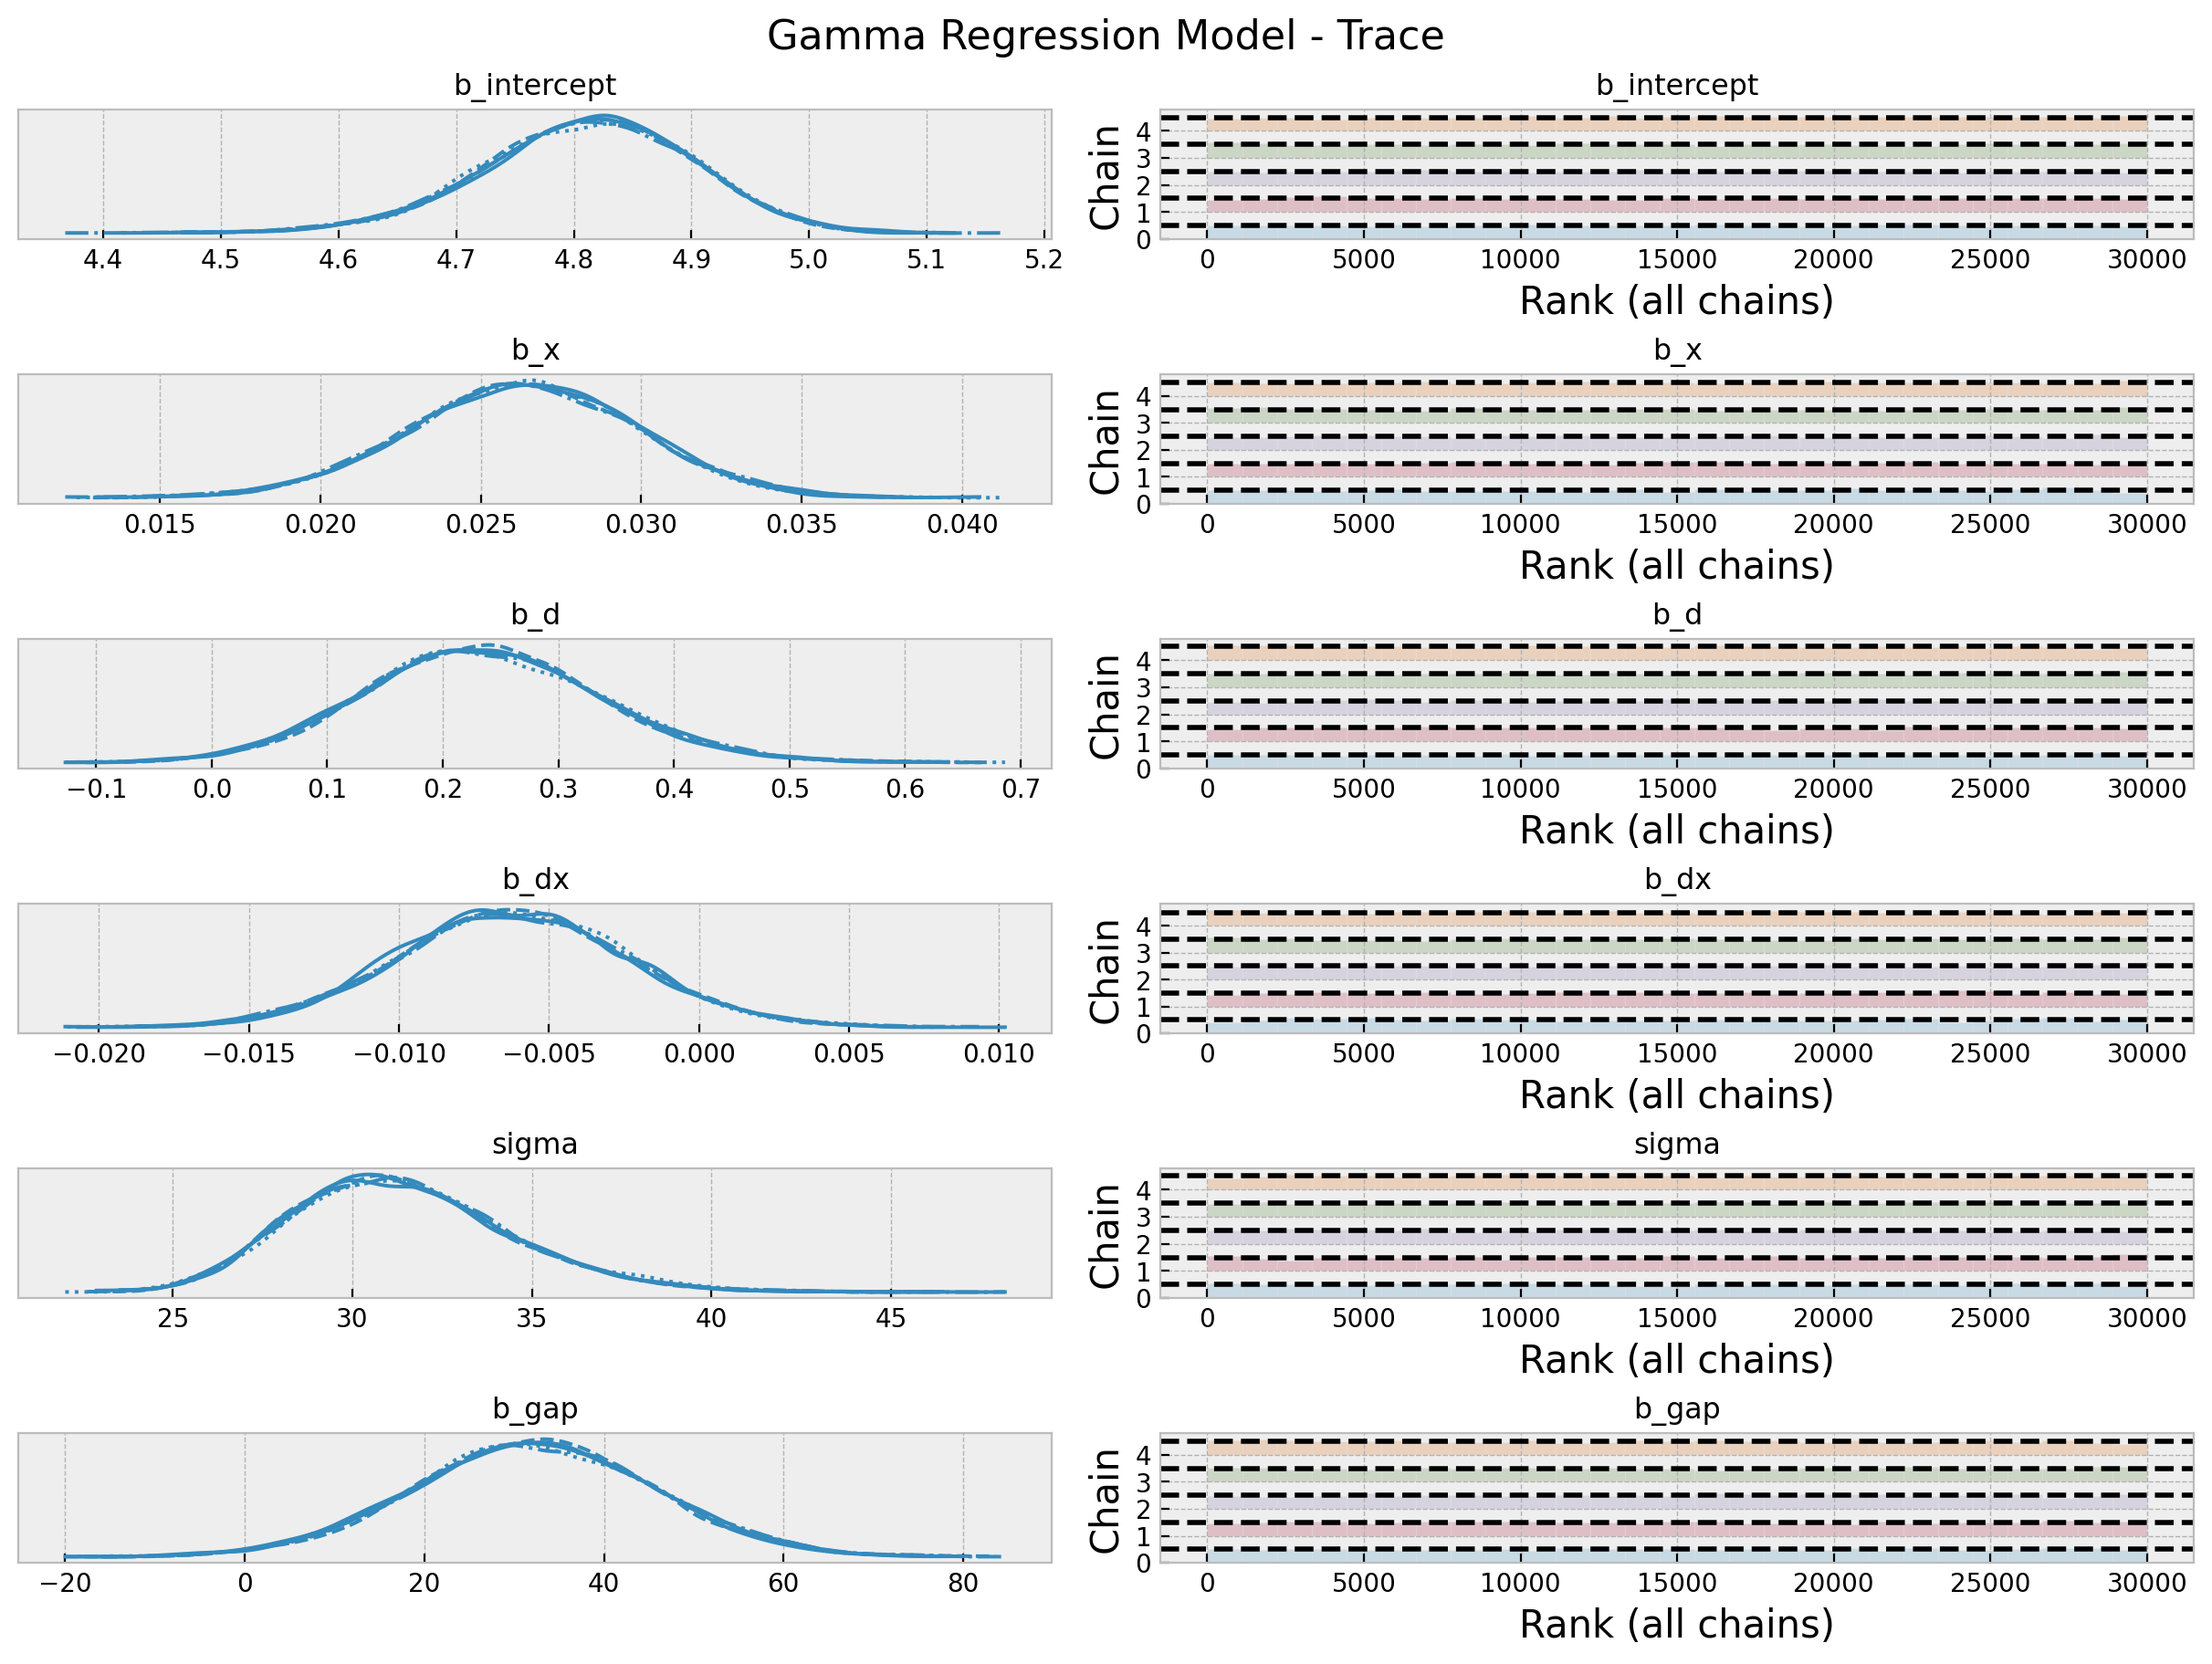

In [24]:
axes = az.plot_trace(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Regression Model - Trace", fontsize=16)


[Text(0.5, 1.0, 'Gamma Regression Model')]

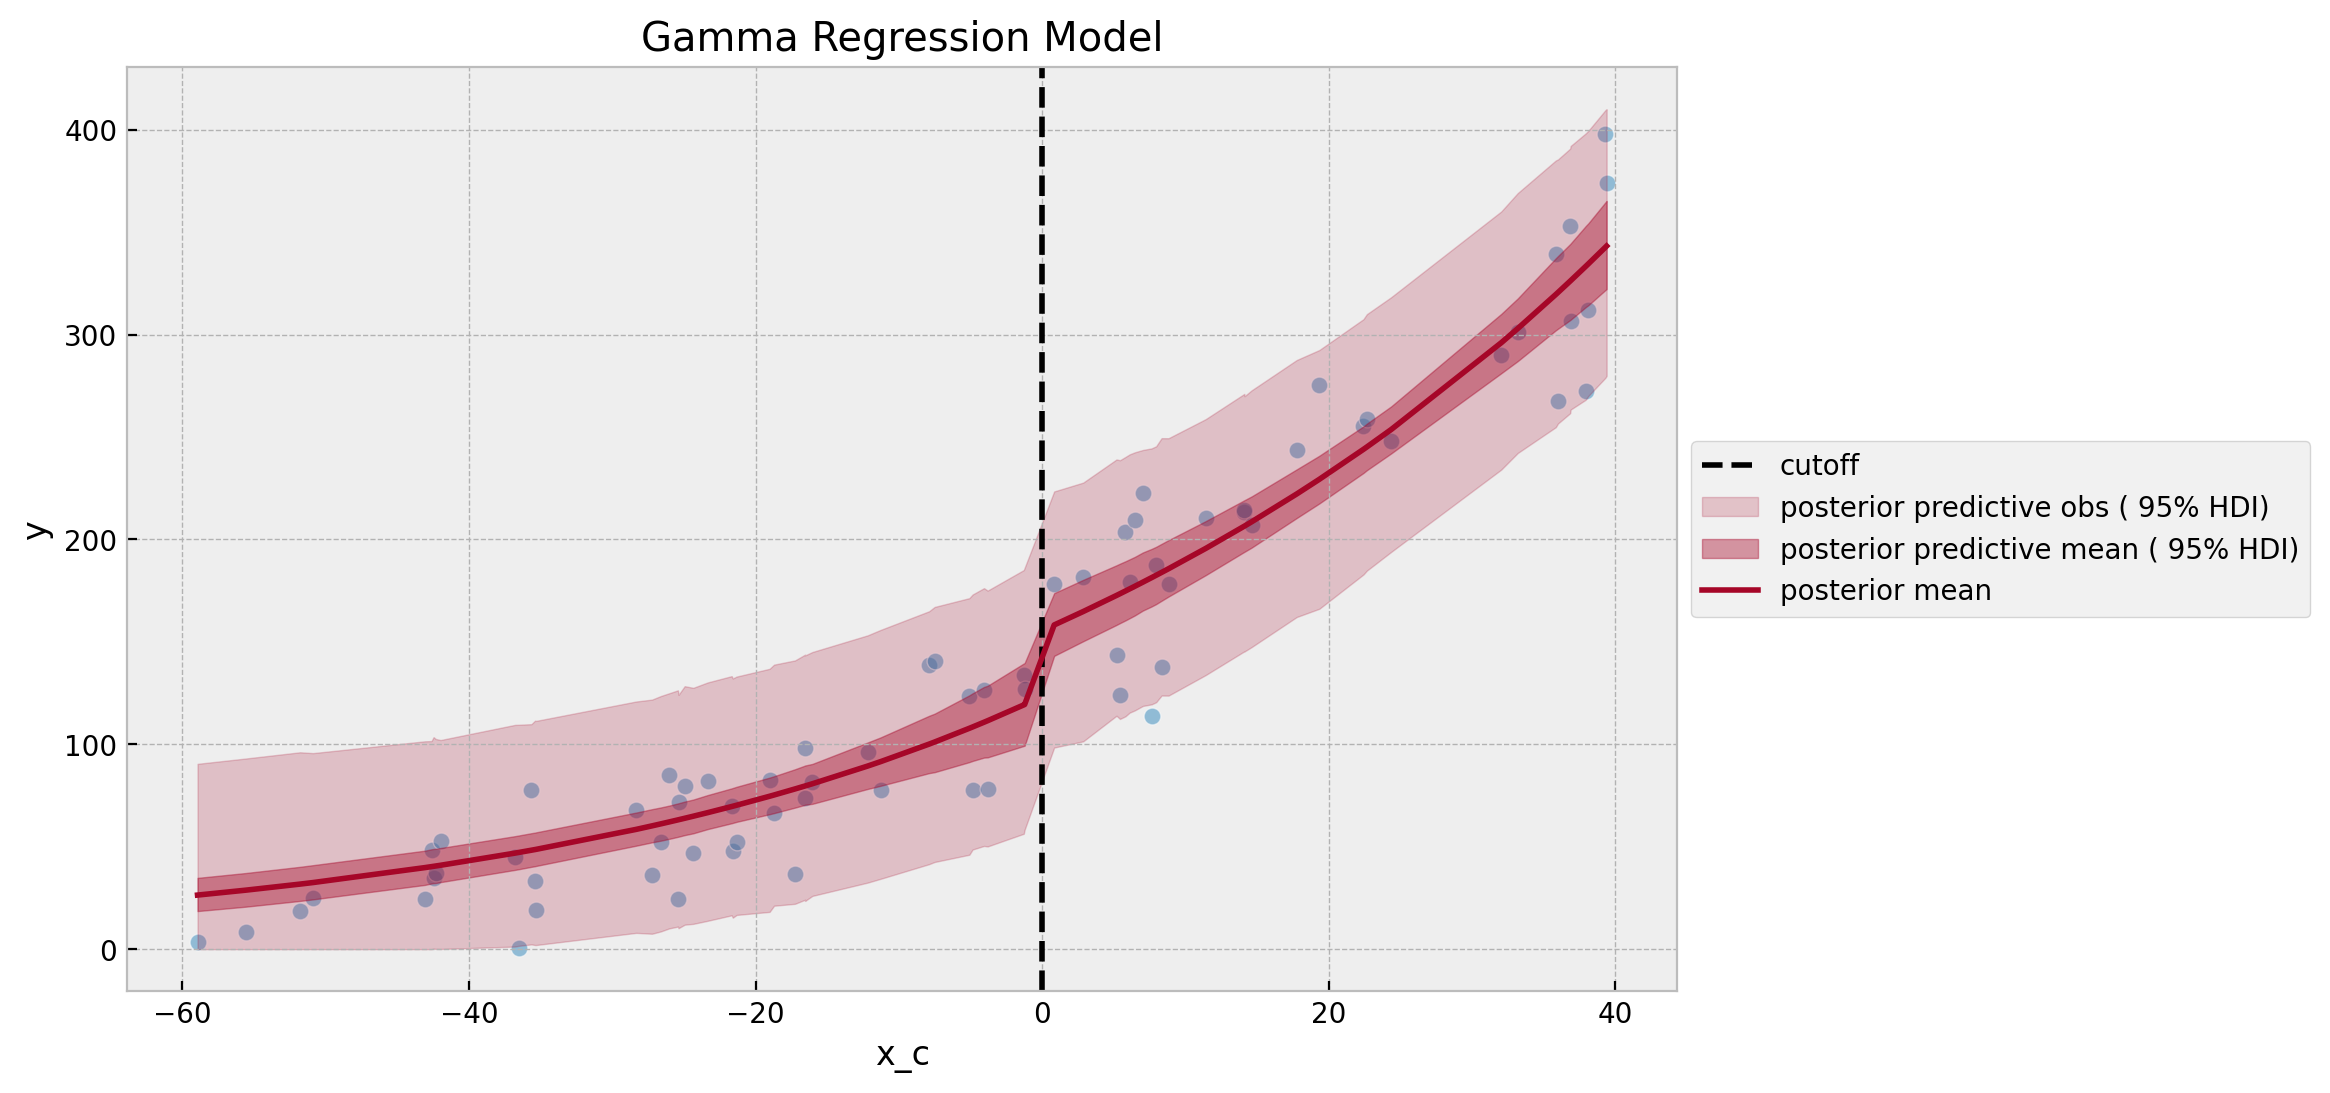

In [25]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")

[Text(0.5, 1.0, 'Kernel Function'),
 Text(0.5, 0, 'time centered'),
 Text(0, 0.5, 'kernel value')]

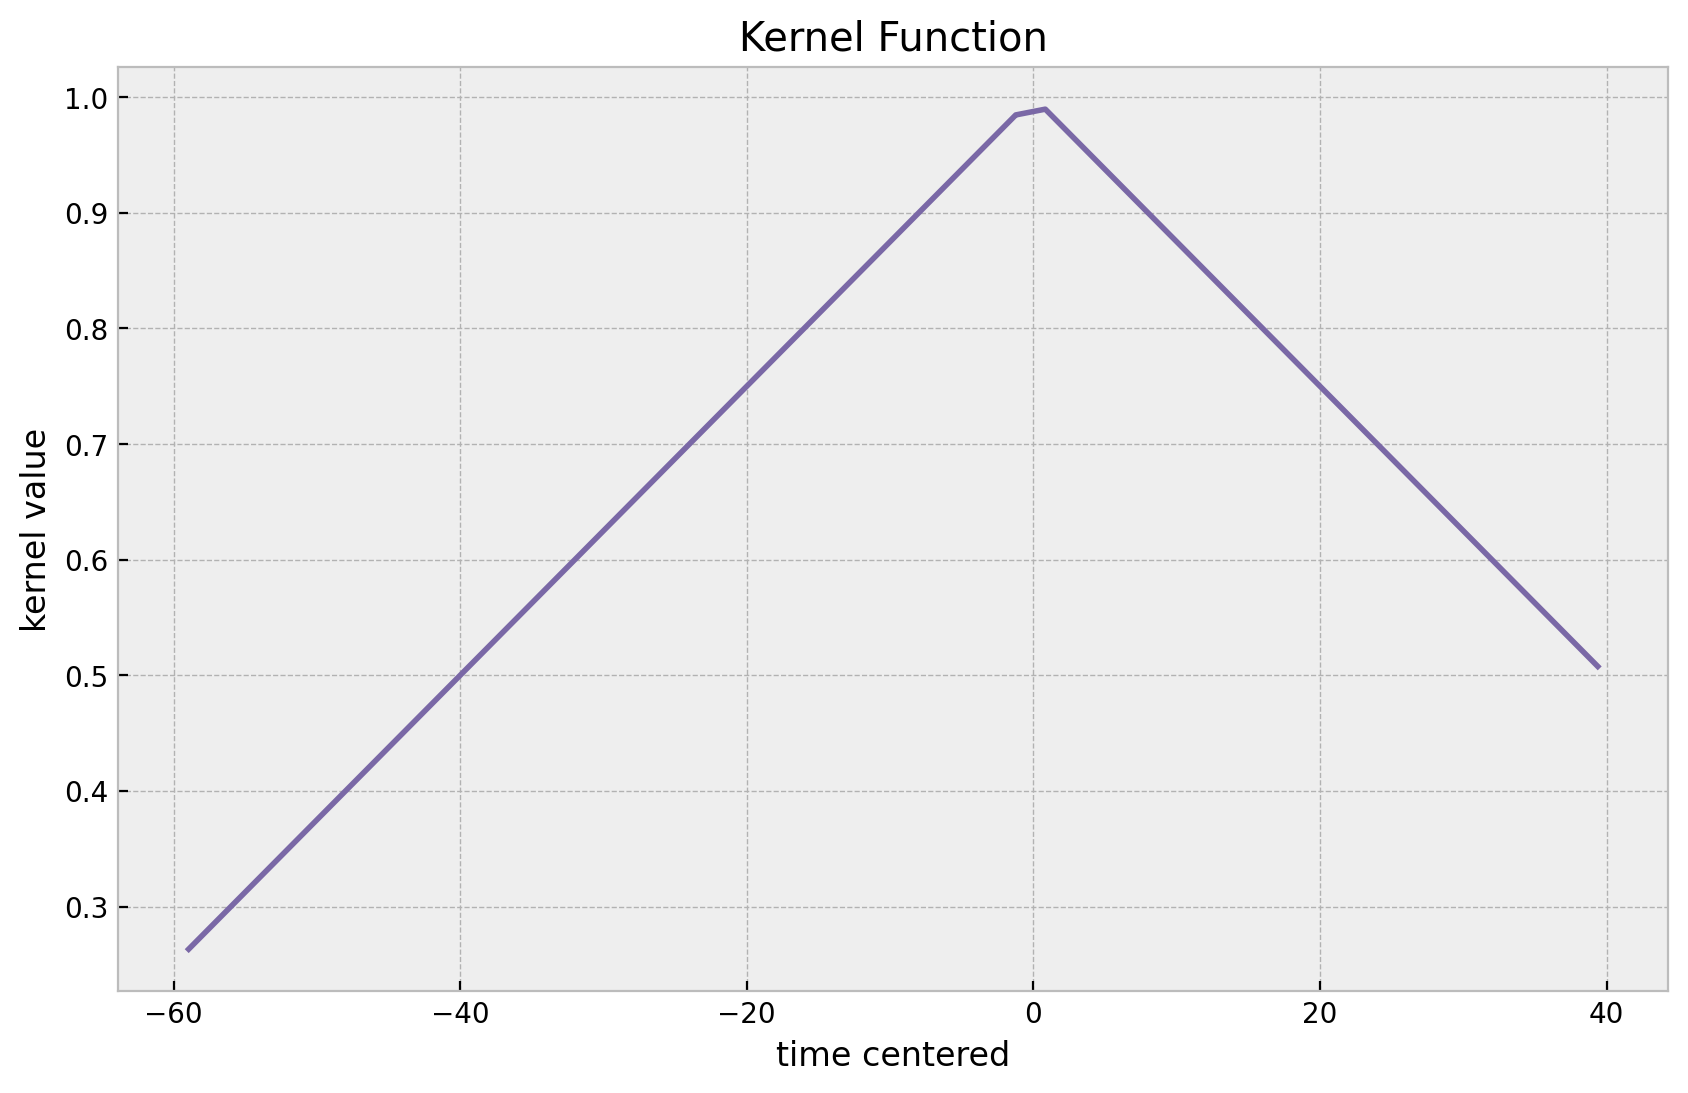

In [26]:
def kernel(r, c, h):
    indicator = (np.abs(r - c) <= h).astype(float)
    return indicator * (1 - np.abs(r - c) / h)


data["kernel"] = kernel(r=data["x_c"], c=0, h=80)
kernel = data["kernel"].to_numpy()

fig, ax = plt.subplots()
sns.lineplot(data=data, x="x_c", y="kernel", color="C2", ax=ax)
ax.set(title="Kernel Function", xlabel="time centered", ylabel="kernel value")


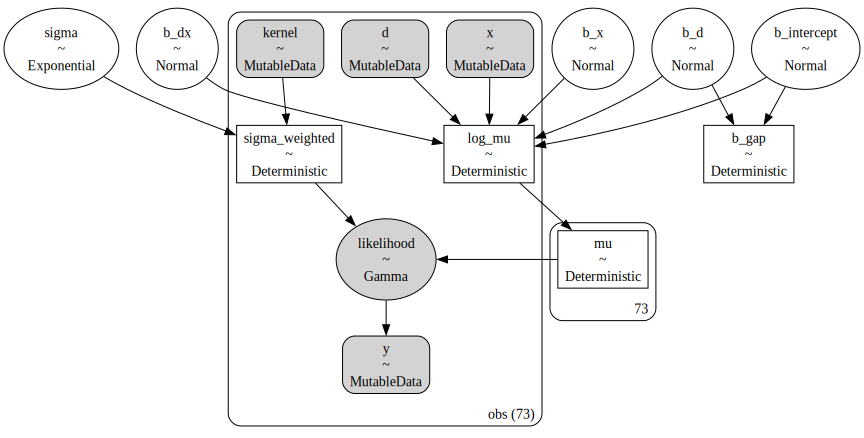

In [27]:
with pm.Model(coords={"obs": obs_idx}) as weighted_gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    kernel_ = pm.MutableData(name="kernel", value=kernel, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(100), sigma=np.log(3.3))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.01))
    b_d = pm.Normal(name="b_d", mu=0, sigma=np.log(1.5))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    eps = np.finfo(float).eps
    sigma_weighted = pm.Deterministic(
        name="sigma_weighted", var=sigma / (kernel_ + eps), dims="obs"
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma_weighted,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=weighted_gamma_model)


In [28]:
with weighted_gamma_model:
    weighted_gamma_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Weighted Gamma Regression Model - Prior Predictive Distribution')]

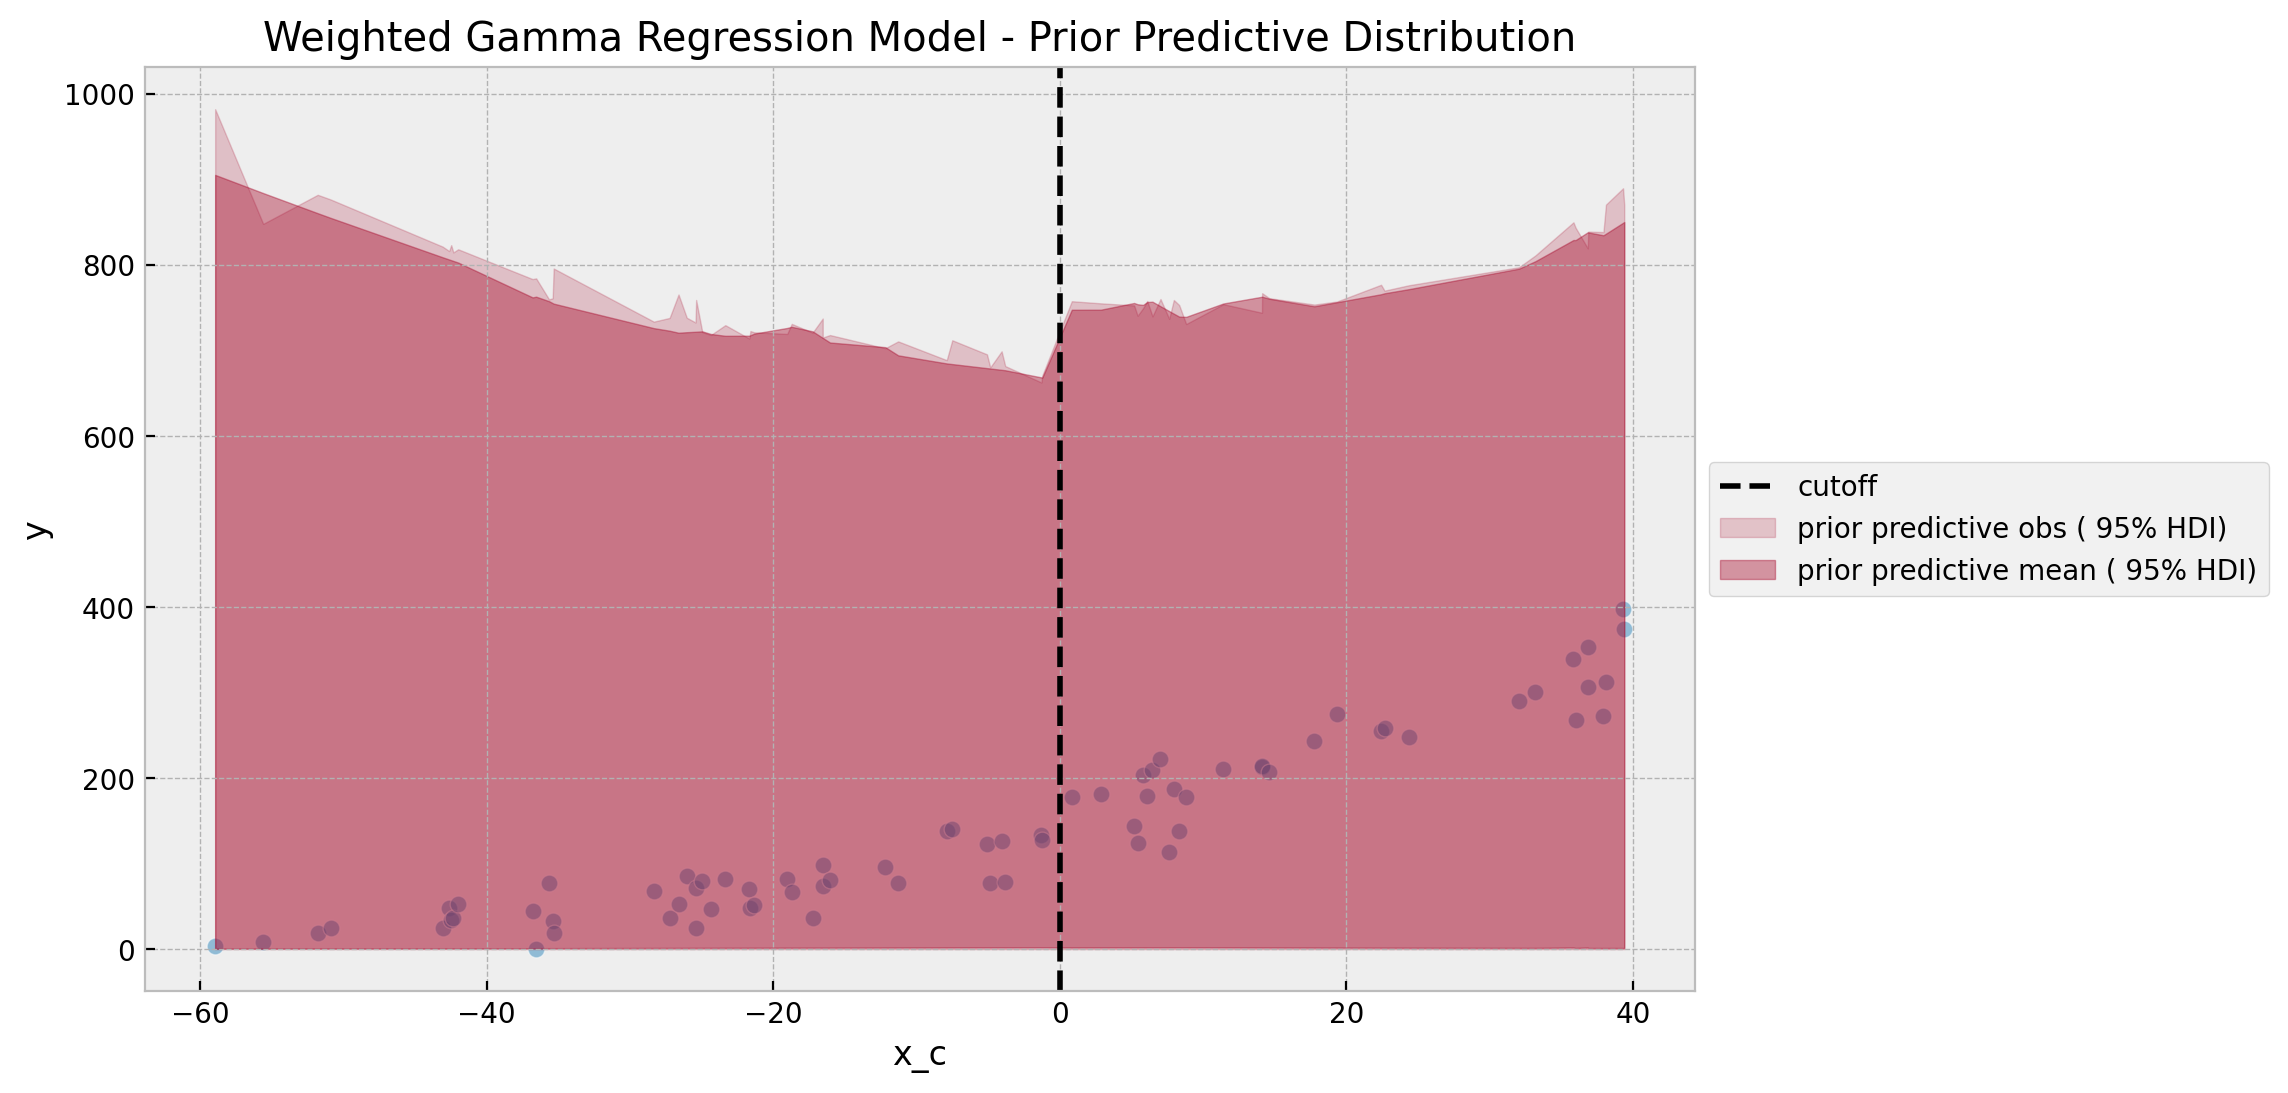

In [29]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Weighted Gamma Regression Model - Prior Predictive Distribution")

[Text(0.5, 1.0, 'Weighted Gamma Regression Model - Discontinuity Prior Predictive Distribution'),
 (-200.0, 200.0)]

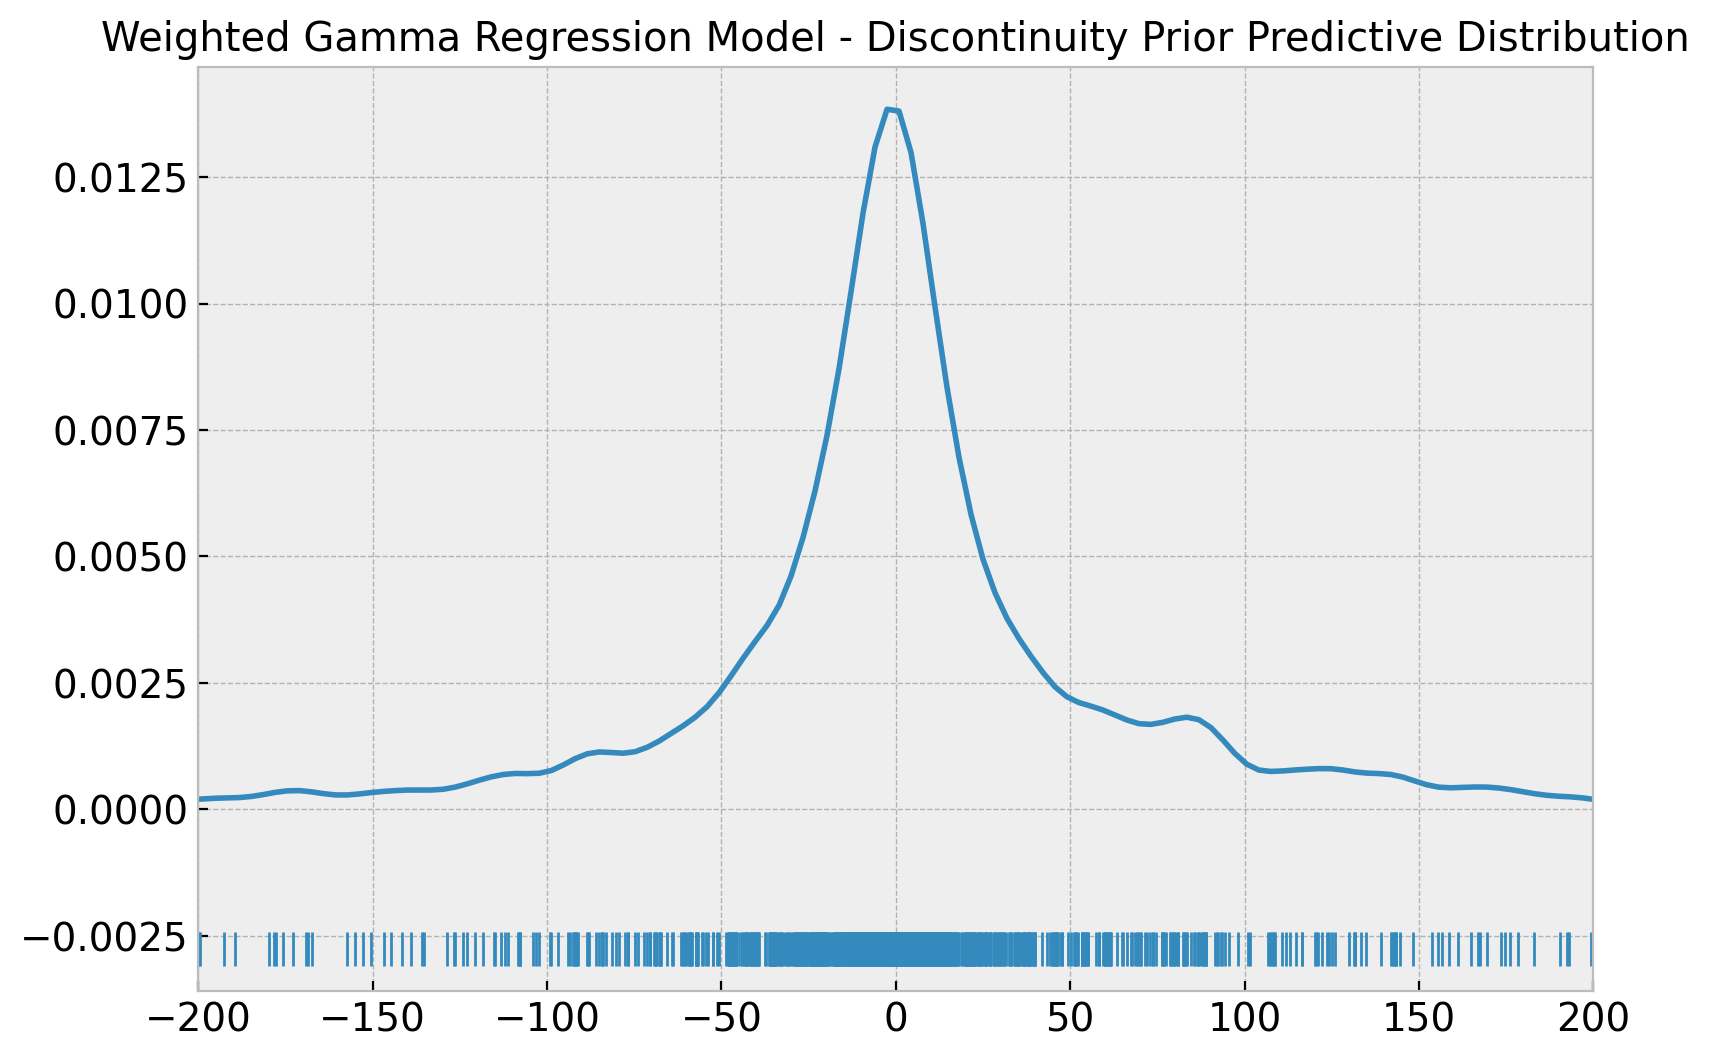

In [30]:
fig, ax = plt.subplots(figsize=(9, 6))
az.plot_dist(
    values=az.extract(
        data=weighted_gamma_prior_predictive, group="prior", var_names=["b_gap"]
    ),
    rug=True,
    ax=ax,
)
ax.set(
    title="Weighted Gamma Regression Model - Discontinuity Prior Predictive Distribution",
    xlim=(-2e2, 2e2),
)


In [31]:
with weighted_gamma_model:
    weighted_gamma_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    weighted_gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=weighted_gamma_idata, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.084463
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:07.140636
Transforming variables...
Transformation time =  0:00:00.163625


Sampling: [likelihood]


In [32]:
weighted_gamma_idata["sample_stats"]["diverging"].sum().item()


0

In [33]:
az.summary(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.766   0.080   4.614    4.914      0.001    0.001    9292.0   
b_x           0.020   0.004   0.013    0.027      0.000    0.000    9513.0   
b_d           0.268   0.092   0.098    0.444      0.001    0.001   10097.0   
b_dx          0.000   0.004  -0.007    0.008      0.000    0.000   10757.0   
sigma        23.741   2.310  19.569   28.109      0.021    0.015   12860.0   
b_gap        35.847  11.683  13.865   57.651      0.112    0.081   10843.0   

             ess_tail  r_hat  
b_intercept   10320.0    1.0  
b_x           10813.0    1.0  
b_d           11333.0    1.0  
b_dx          13211.0    1.0  
sigma         15138.0    1.0  
b_gap         12668.0    1.0

Text(0.5, 0.98, 'Weighted Gamma Regression Model - Trace')

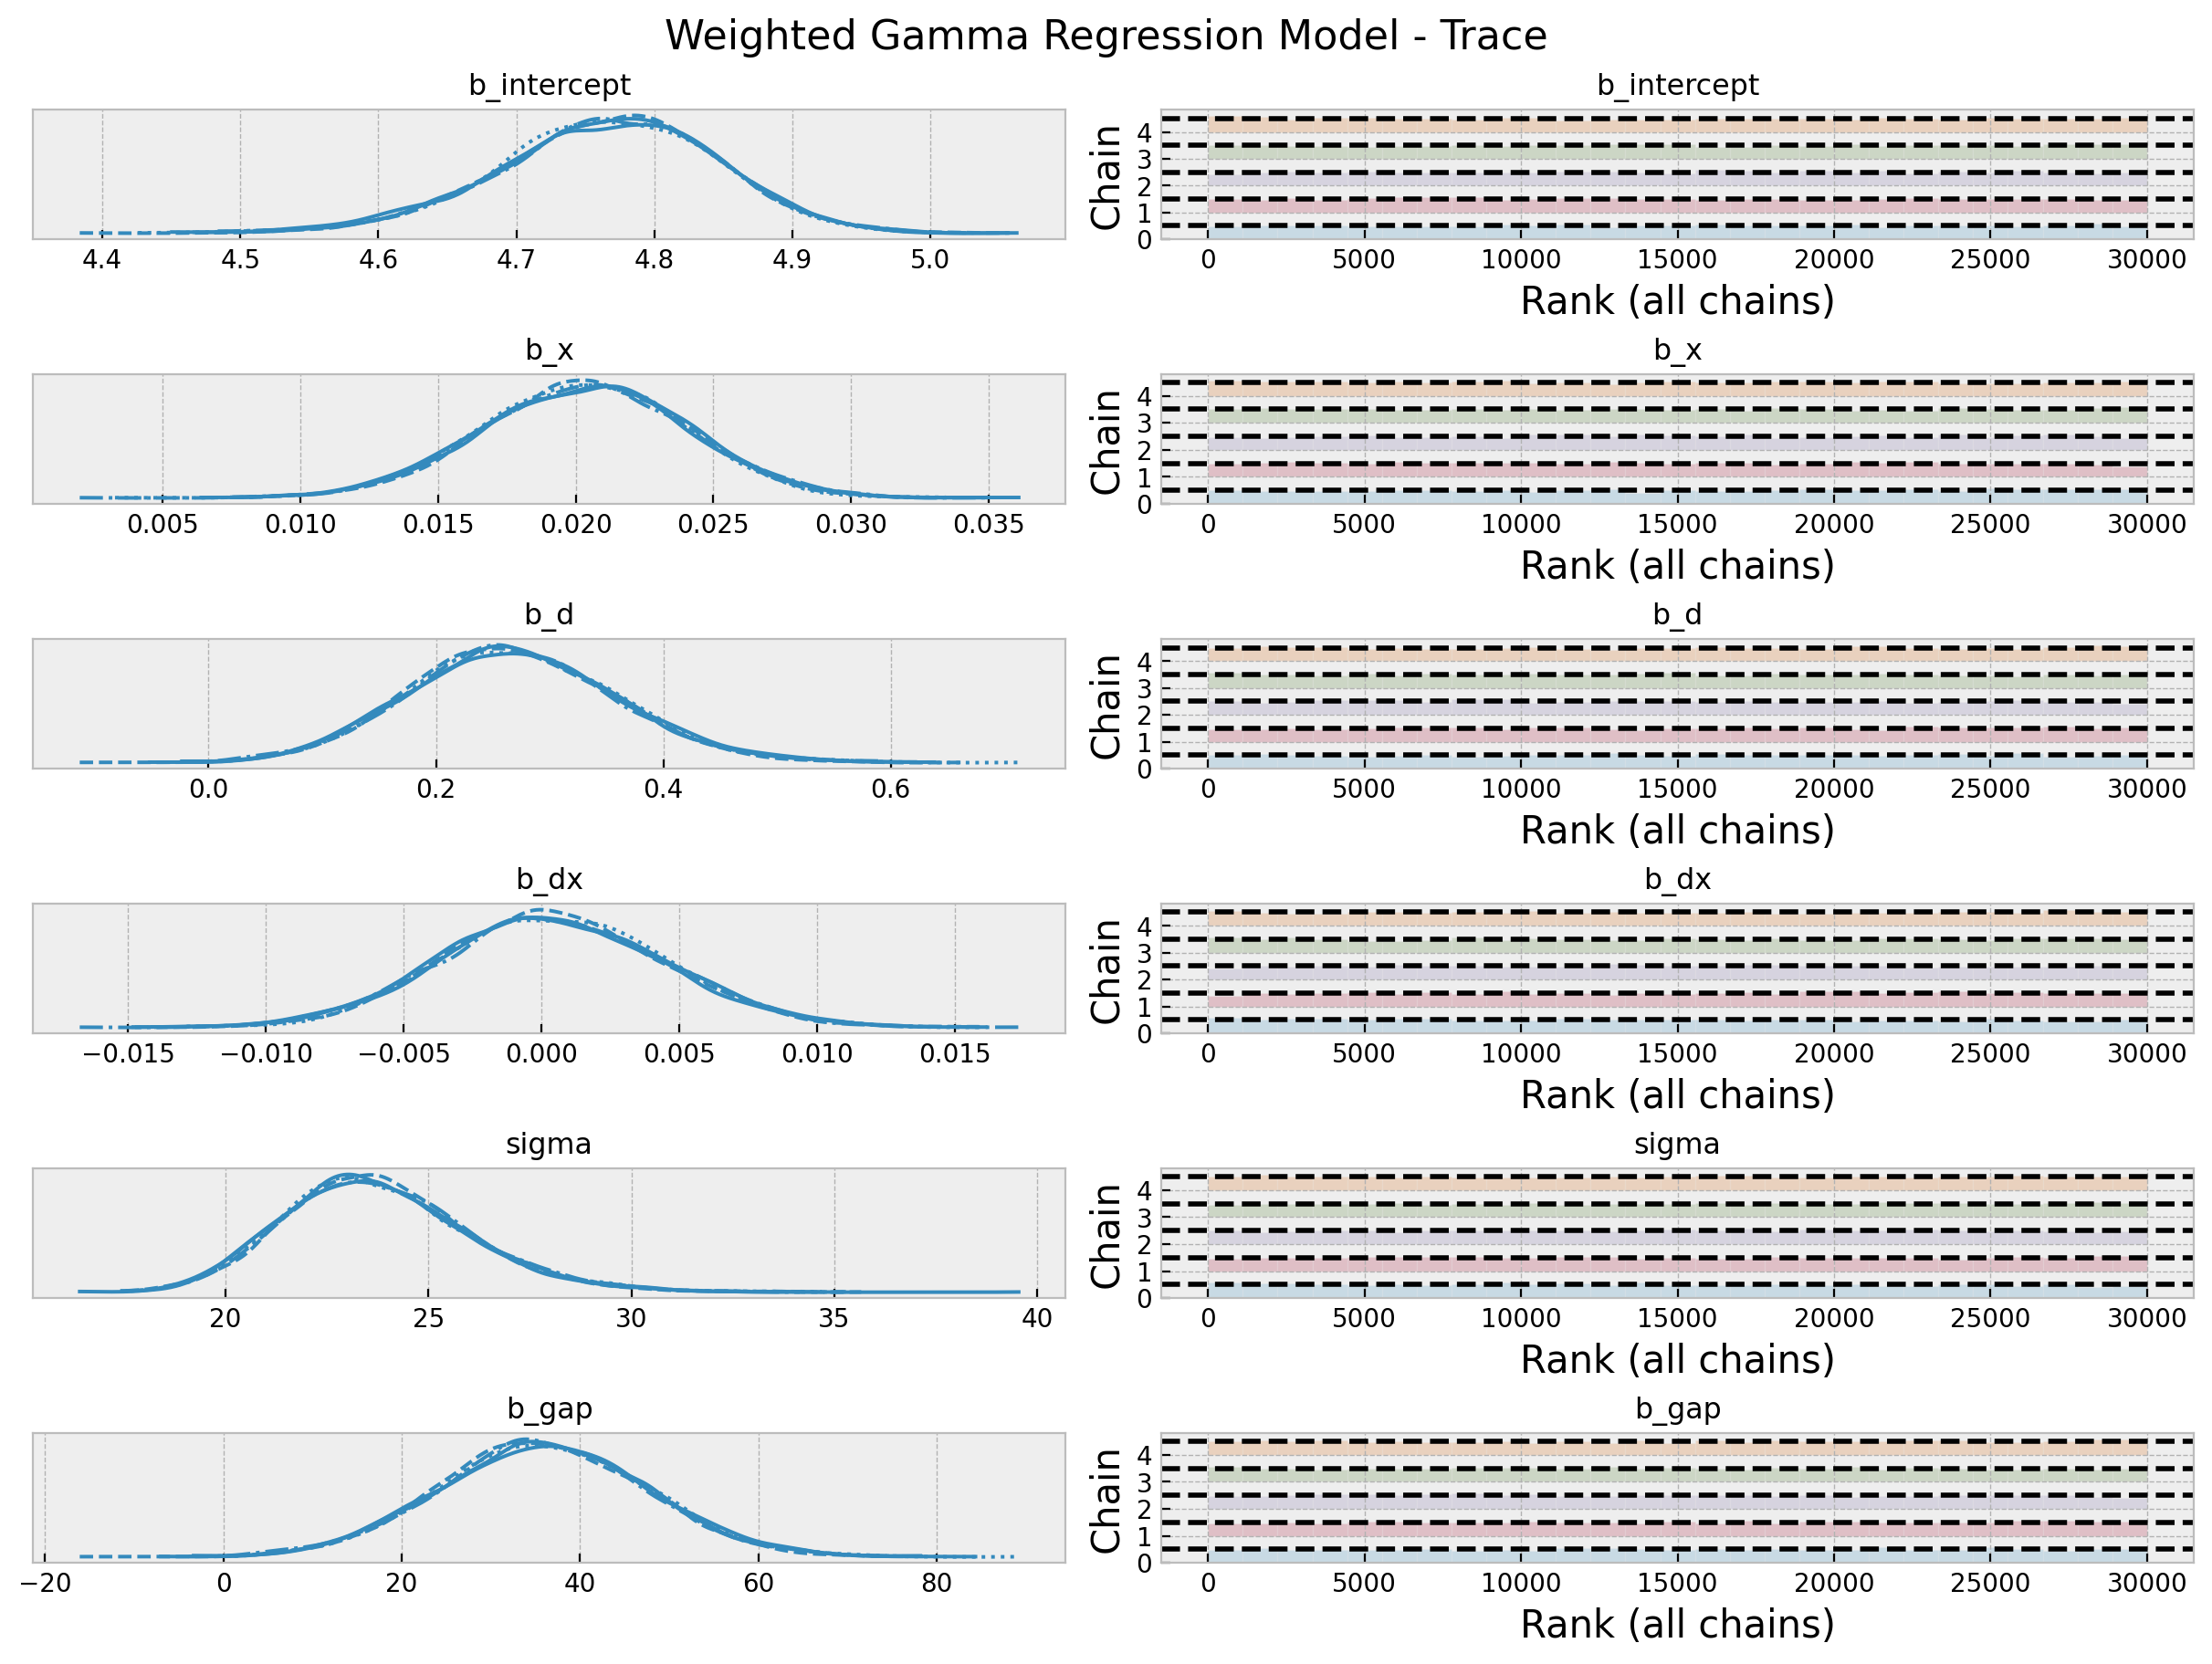

In [34]:
axes = az.plot_trace(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Weighted Gamma Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Gamma Regression Model')]

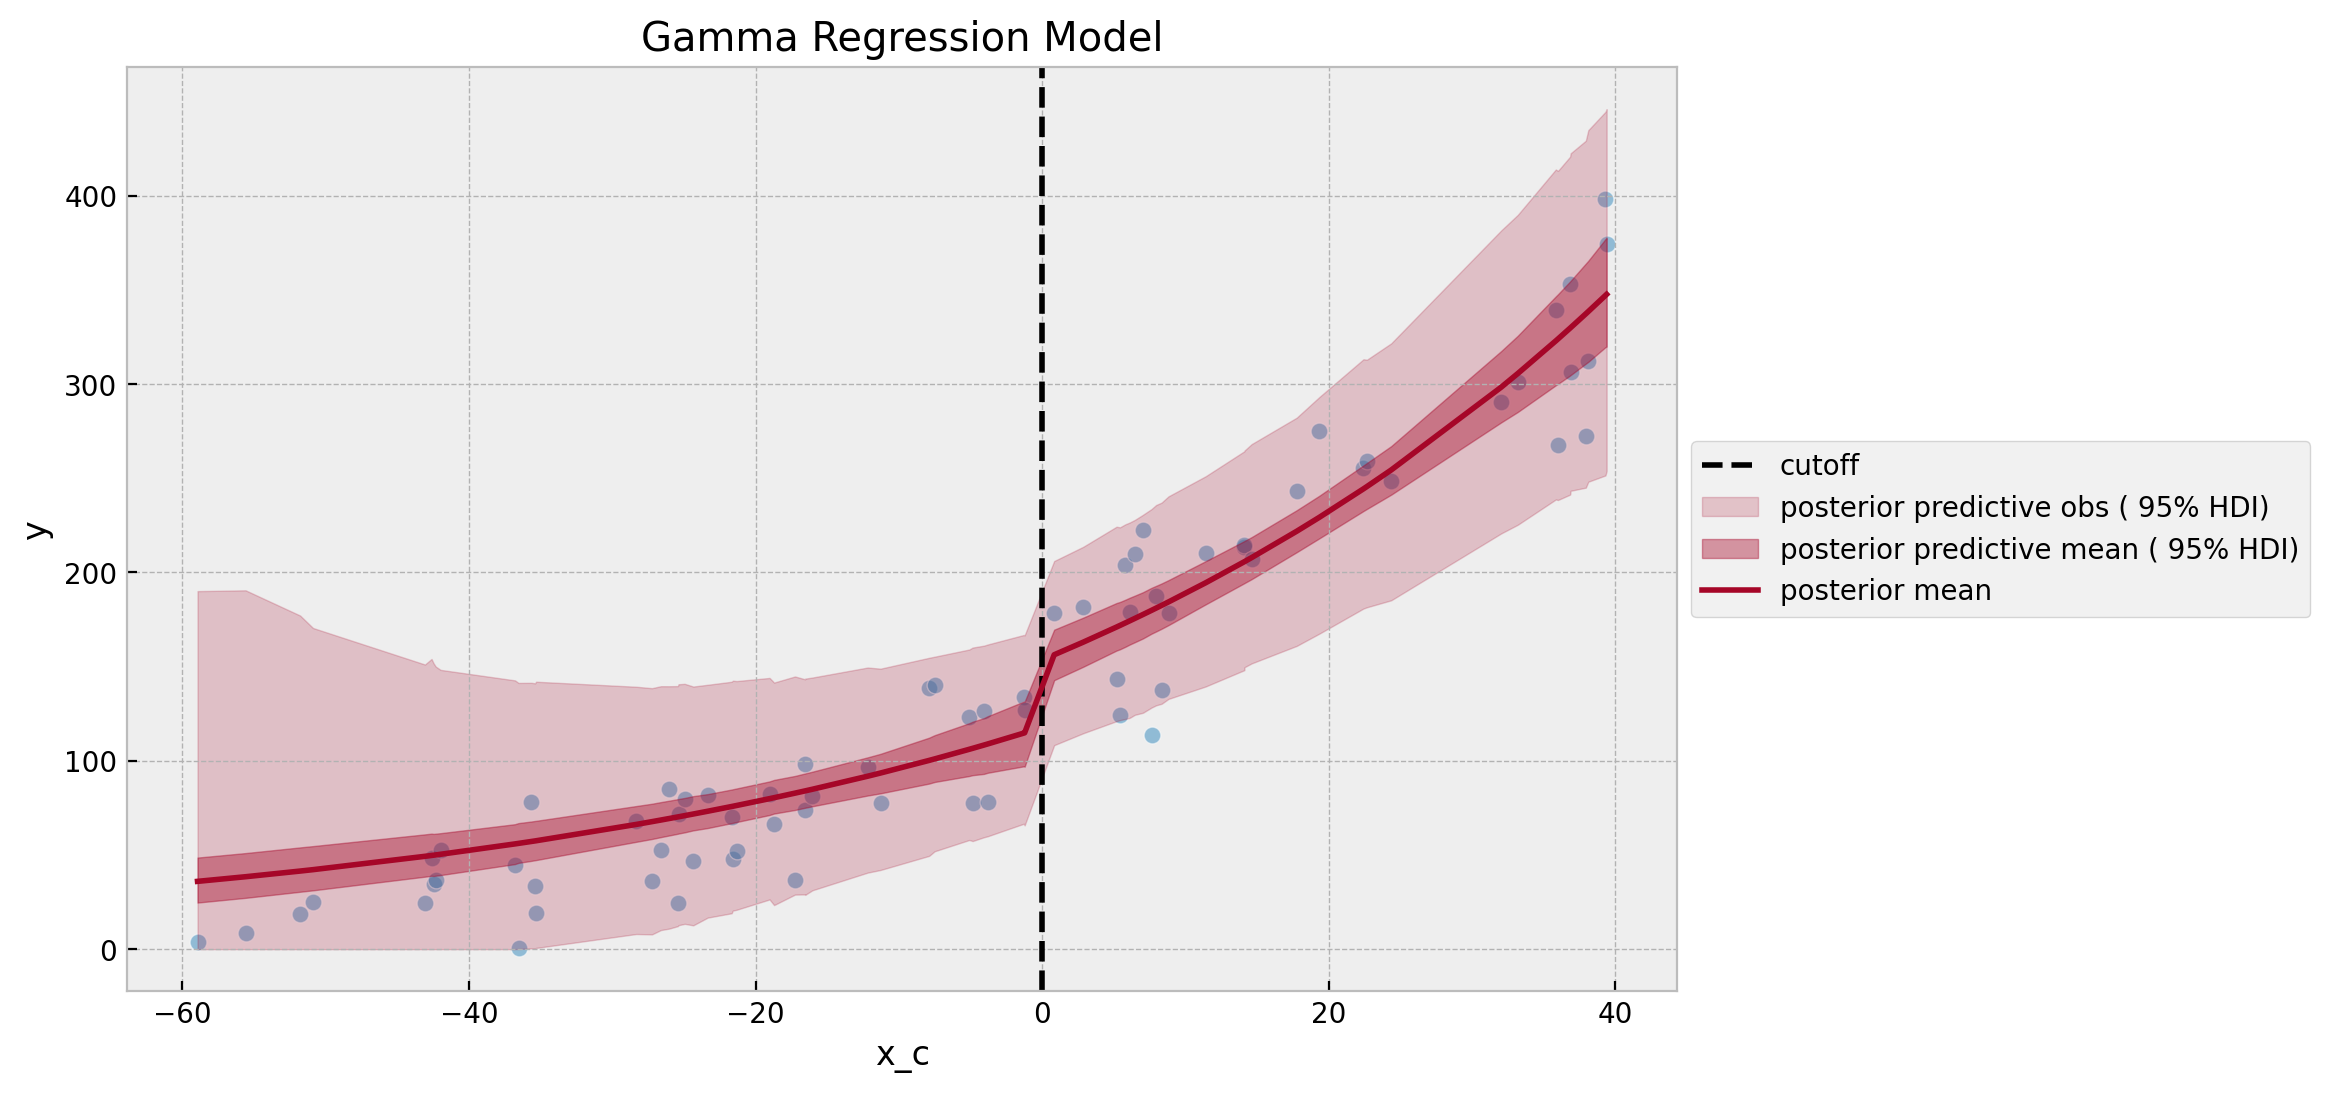

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=weighted_gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")

Text(0.5, 1.06, 'Estimated Discontinuity Posterior Distributions')

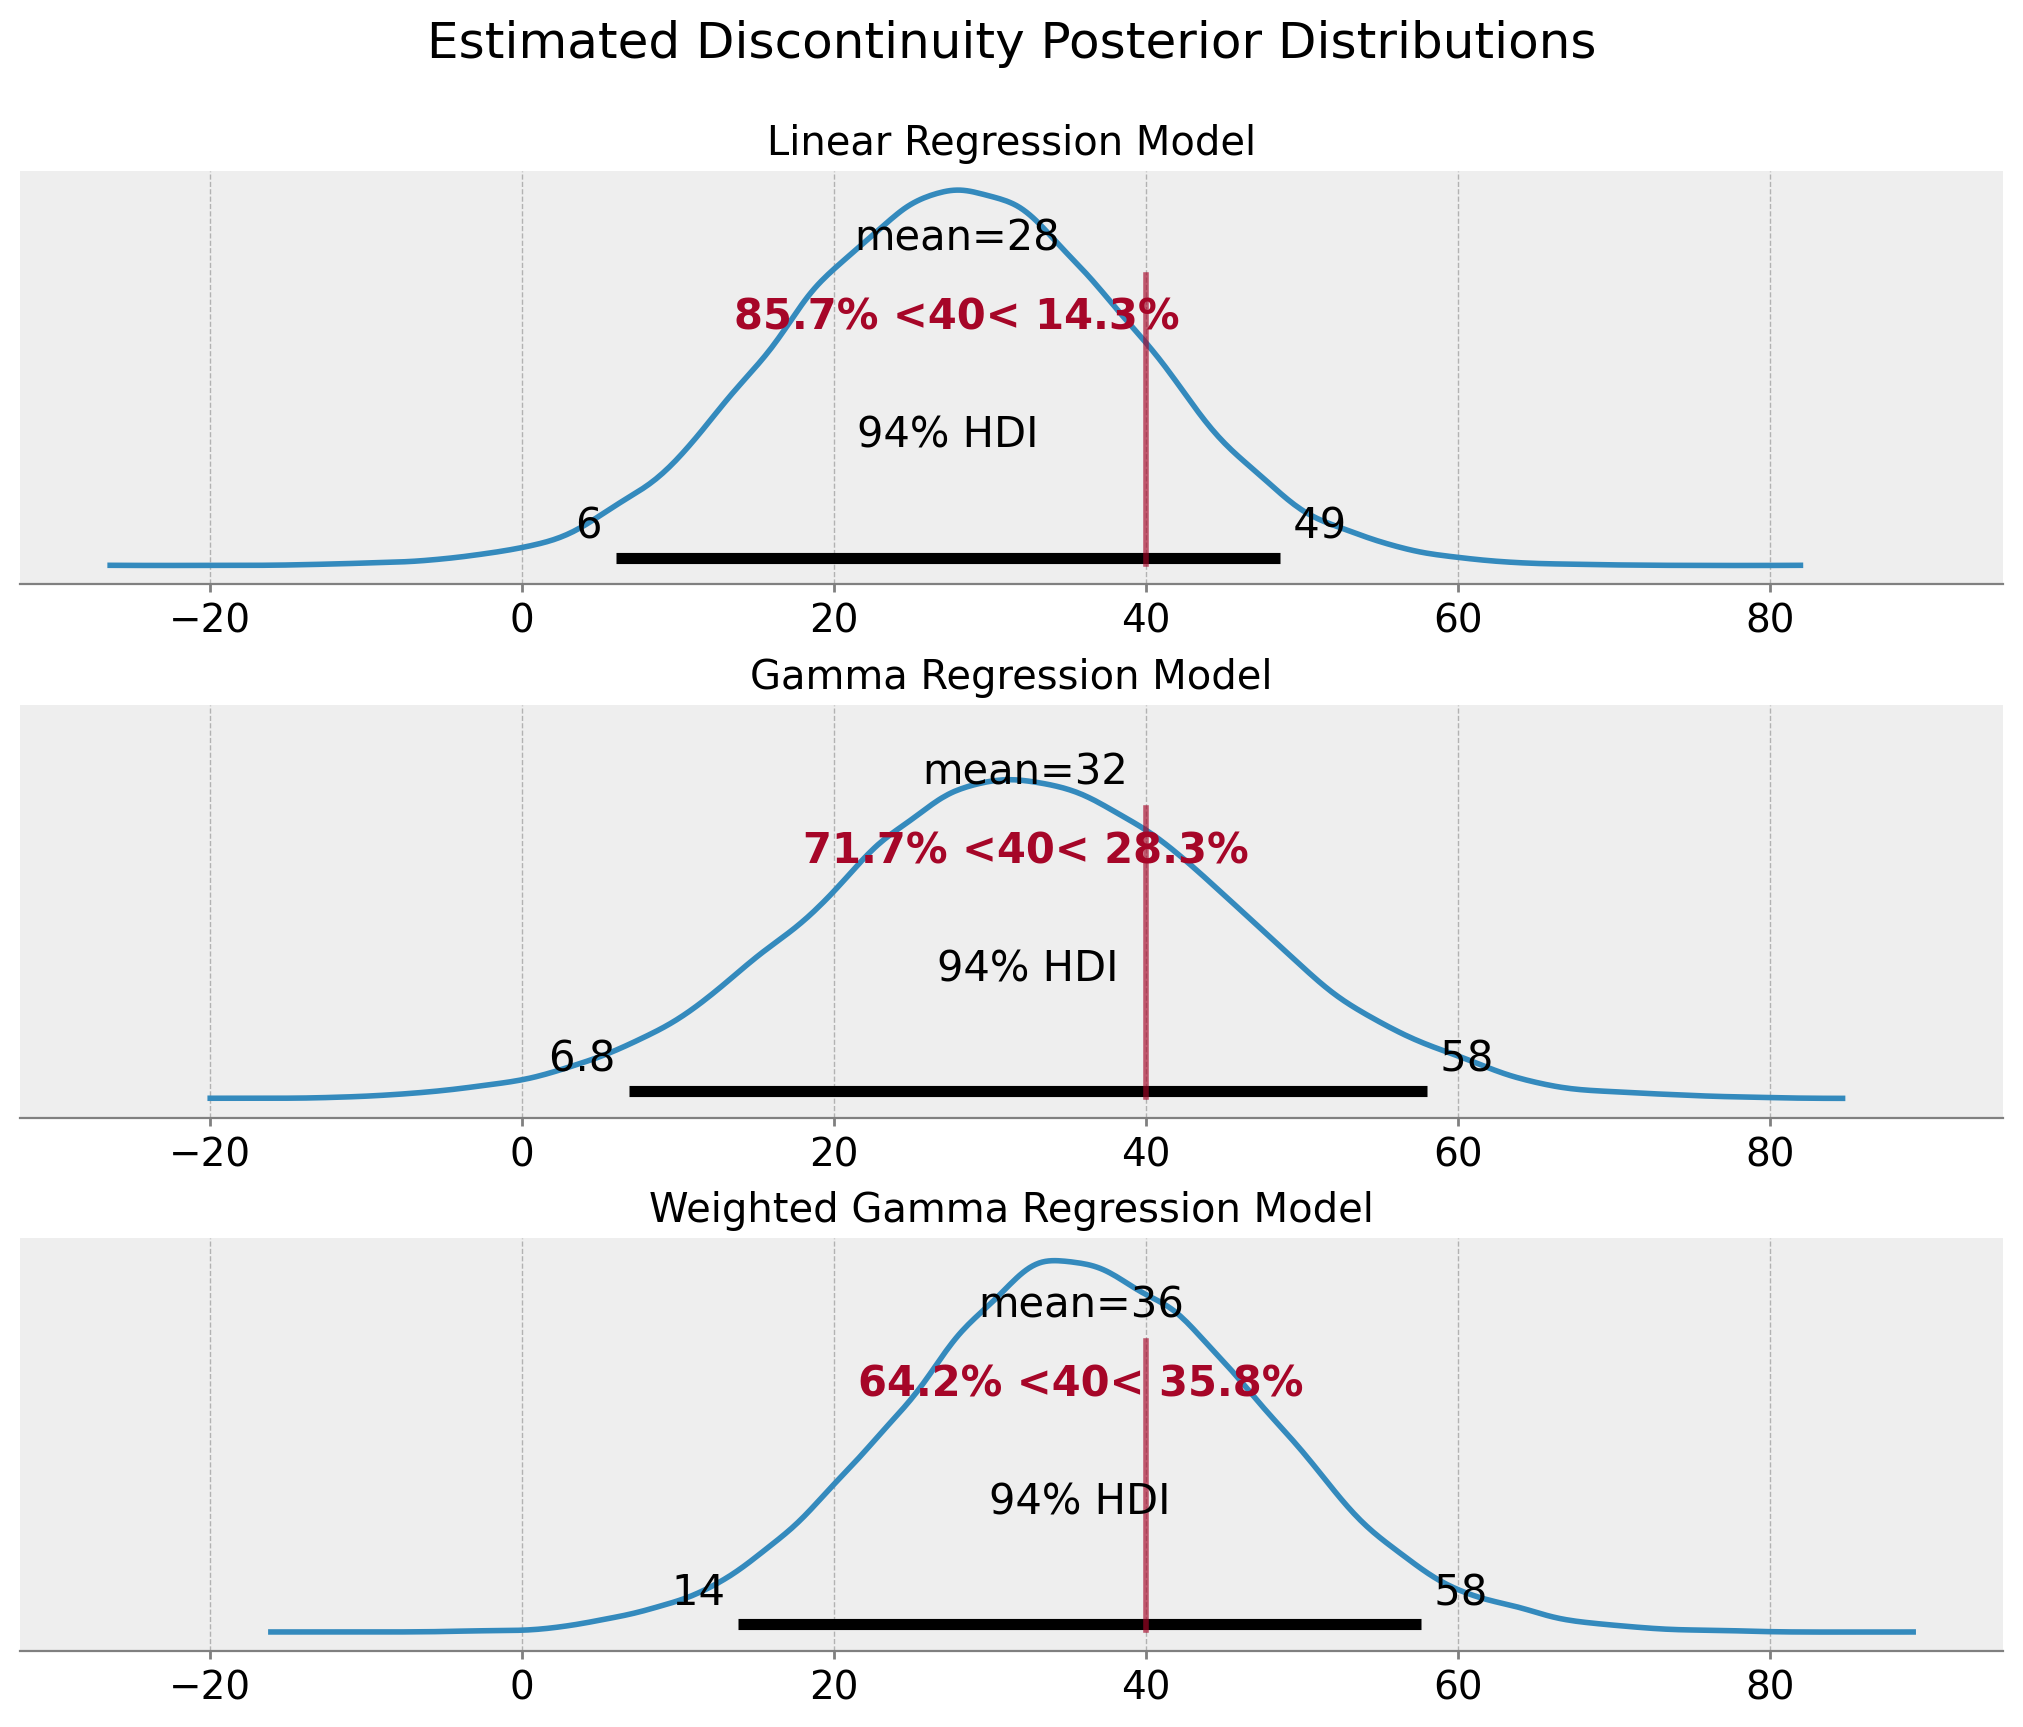

In [36]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=gaussian_idata, var_names=["b_d"], ref_val=delta_true, ax=ax[0])
ax[0].set(title="Linear Regression Model")
az.plot_posterior(data=gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[1])
ax[1].set(title="Gamma Regression Model")
az.plot_posterior(
    data=weighted_gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[2]
)
ax[2].set(title="Weighted Gamma Regression Model")
fig.suptitle("Estimated Discontinuity Posterior Distributions", fontsize=18, y=1.06)
